# Simple CNN for compare default parameters in further applications
#### Previous adversial ensemble network will be created in another file

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #If using Matplotlib on Windows with different versions, this will surpress error
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import statistics 
from scipy import ndimage #Image Smoothing
from collections import Counter
import foolbox as fb
from torch.autograd import Variable
device = torch.device("cpu")
import sys
sys.path.append('../src/functions')
from clean_nn_weights import reset_weights    

#Git merge main/main master

Define dataloader parameter

In [2]:
batch_size_train = 32
batch_size_test = 32
random_seed = 1337
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.manual_seed(random_seed)  #Static random seed for reproducibility

Load MNIST Dataset from torchvision

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True, drop_last=True,worker_init_fn=random_seed)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True,drop_last=True,worker_init_fn=random_seed)

Load CIFAR10 Da taset from torchvision

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                                 (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                                torchvision.transforms.Resize(size=(28,28))
                             ])),
  batch_size=batch_size_train, shuffle=True, drop_last=True,worker_init_fn=random_seed)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                                torchvision.transforms.Resize(size=(28,28))
                             ])),
  batch_size=batch_size_test, shuffle=True,drop_last=True,worker_init_fn=random_seed)

Files already downloaded and verified
Files already downloaded and verified


#### Quick analysis of class balances

Min: 0.0006402533035725355
Max: 1.0
0.9993597


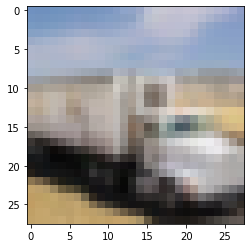

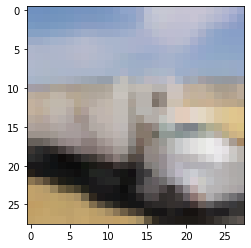

In [43]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)
print("Min: {}".format(min(np.ravel(x_d))))
print("Max: {}".format(max(np.ravel(x_d))))
print(abs(min(np.ravel(x_d))-max(np.ravel(x_d))))
#img = np.transpose(img, axes=[1, 2, 0])  # Put the 0-th dimension at the end
    
    # Image are supposed to be unsigned 8-bit integers. If we keep the raw images, then
    # this line is not needed. However, if we normalize or whiten the image, then the values become
    # floats. So we need to convert them back to uint8s.
plt.imshow(np.transpose(x_d[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(median_smoothing(x_d)[31], axes=[1, 2, 0]))
plt.show()



Min: 0.0
Max: 1.0
1.0


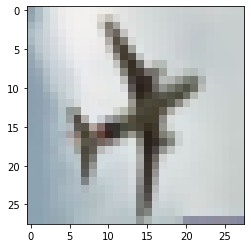

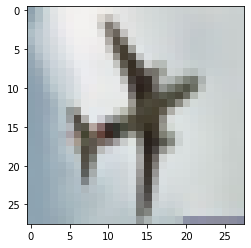

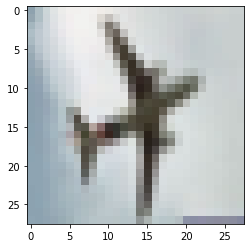

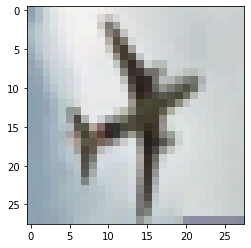

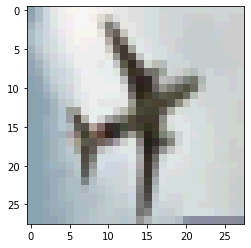

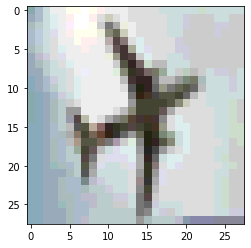

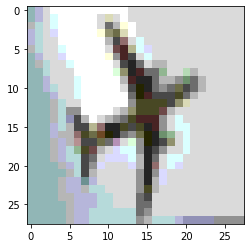

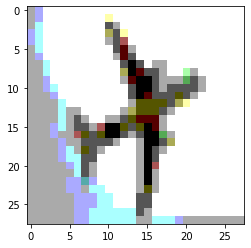

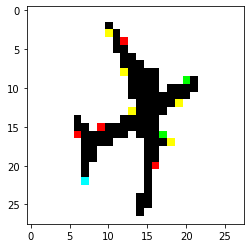

In [10]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)
print("Min: {}".format(min(np.ravel(x_d))))
print("Max: {}".format(max(np.ravel(x_d))))
print(abs(min(np.ravel(x_d))-max(np.ravel(x_d))))
#img = np.transpose(img, axes=[1, 2, 0])  # Put the 0-th dimension at the end
    
    # Image are supposed to be unsigned 8-bit integers. If we keep the raw images, then
    # this line is not needed. However, if we normalize or whiten the image, then the values become
    # floats. So we need to convert them back to uint8s.
plt.imshow(np.transpose(x_d[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=8)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=7)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=6)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=5)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=4)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=3)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=2)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=1)[31], axes=[1, 2, 0]))
plt.show()


In [5]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)
print("Min: {}".format(min(np.ravel(x_d))))
print("Max: {}".format(max(np.ravel(x_d))))
print(abs(min(np.ravel(x_d))-max(np.ravel(x_d))))
#img = np.transpose(img, axes=[1, 2, 0])  # Put the 0-th dimension at the end
    
    # Image are supposed to be unsigned 8-bit integers. If we keep the raw images, then
    # this line is not needed. However, if we normalize or whiten the image, then the values become
    # floats. So we need to convert them back to uint8s.
plt.imshow(np.transpose(x_d[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=8)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=7)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=6)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=5)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=4)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=3)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=2)[31], axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose(bit_reduction(x_d,bit=1)[31], axes=[1, 2, 0]))
plt.show()


NameError: name 'extract_dataloader_images' is not defined

In [48]:
print(train_loader.dataset.train_data.size())
print(test_loader.dataset.test_data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


f:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
f:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [41]:
nr_train = np.array([])
for i, (data, target) in enumerate(train_loader):
    nr_train=np.append(nr_train, target.cpu().detach().numpy())

nr_test = np.array([])
for i, (data, target) in enumerate(test_loader):
    nr_test=np.append(nr_test, target.cpu().detach().numpy())

In [14]:
Counter(np.sort(nr_train))

Counter({0.0: 6902,
         1.0: 7875,
         2.0: 6988,
         3.0: 7140,
         4.0: 6822,
         5.0: 6311,
         6.0: 6874,
         7.0: 7292,
         8.0: 6824,
         9.0: 6956})

In [11]:
Counter(np.sort(nr_test))

Counter({0.0: 979,
         1.0: 1133,
         2.0: 1030,
         3.0: 1009,
         4.0: 980,
         5.0: 890,
         6.0: 956,
         7.0: 1027,
         8.0: 973,
         9.0: 1007})

In [4]:
def extract_dataloader_images(epoch):
  #for batch_idx, (data, target) in enumerate(train_loader):
  examples = enumerate(test_loader,start=0)
  _, (example_data, example_targets) = next(examples)
  return(example_data, example_targets)

def count_perturbated_pixel(img1,img2):
  sum_px = 28*28
  sum_px_perturbed = 0
  for px_img1,px_img2 in zip(img1[0][0],img2[0][0]): #Zip Array of Pixels
    for px_im1,px_im2 in zip(px_img1,px_img2): #Zip Pixels
        if (px_im1 != px_im2):
            sum_px_perturbed+=1
  return((sum_px_perturbed/sum_px),sum_px,sum_px_perturbed)

def perturbate_image(img_data,mode='random',value=100):
  if (mode=='random'):
      for i in range(value):
          img_data[0][0][random.randrange(1,28),random.randrange(1,28)]=random.uniform(min(np.ravel(img_data)),max(np.ravel(img_data)))
  elif (mode=='random_white'):
      for i in range(value):
          img_data[0][0][random.randrange(1,28),random.randrange(1,28)]=round(max(np.ravel(img_data)))
  return(img_data)

def median_smoothing(img_data,kernel_size=2):
  from scipy import ndimage
  img_data_median = torch.clone(img_data)
  if  "CIFAR" in str(test_loader.dataset):
    for i in range(img_data_median.shape[0]):
      for j in range(img_data_median.shape[1]): #RGB Values
        img_data_median[i][j] = torch.from_numpy(ndimage.median_filter(img_data_median[i][j], size=kernel_size))
  else:  
    #print(img_data_median.shape.__len__())
    if (img_data_median.shape.__len__() > 2):
      for i in range(img_data_median.shape[0]):
        img_data_median[i][0] = torch.from_numpy(ndimage.median_filter(img_data_median[i][0], size=kernel_size))
    else:
      img_data_median = torch.from_numpy(ndimage.median_filter(img_data_median, size=kernel_size))
  return(img_data_median)

def bit_reduction(img_data,clip_min=0.499999,clip_max=0.5,bit=4):

  img_data_bit = torch.clone(img_data)
 
  img_min = min(np.ravel(img_data_bit))
  img_max = max(np.ravel(img_data_bit))

  if  "CIFAR" in str(test_loader.dataset):
    step_size = abs(img_min-img_max)/(pow(2,bit)-1)
    steps = pow(2,bit)
    #print("Steps: ",steps)
    #print("Step size: ",step_size)
    #print("Distance: ",abs(img_min-img_max))
    #print("Min: ",img_min)
    #print("Max: ",img_max)
    #steps = 4
    reduced_data = (img_data_bit-min(np.ravel(img_data_bit))) / (max(np.ravel(img_data_bit)) - min(np.ravel(img_data_bit)))
    step_size_norm = abs(min(np.ravel(reduced_data))-max(np.ravel(reduced_data)))/pow(2,bit)
    #print("Step size norm: ",step_size_norm)
    for i in range(img_data_bit.shape[0]):
      for j in range(img_data_bit.shape[1]): #RGB Values
        for k in range(steps):
          #print("Greater than: ",step_size_norm*k)
          #print("Lesser than: ",step_size_norm*(k+1))
          #print("K: ",k)
          reduced_data[i][j][(reduced_data[i][j]>=(step_size_norm*(k))) & (reduced_data[i][j]<=step_size_norm*(k+1))] = img_min+(k*step_size)
          #reduced_data[i][j][reduced_data[i][j]<step_size] = torch.from_numpy(np.array(img_min))
          #reduced_data[i][j][(reduced_data[i][j]>=step_size) & (reduced_data[i][j]<step_size*2)] = torch.from_numpy(np.array(img_min+step_size))
          #reduced_data[i][j][(reduced_data[i][j]>=step_size*2) & (reduced_data[i][j]<step_size*3)] = torch.from_numpy(np.array(img_min+step_size*2))
          #reduced_data[i][j][reduced_data[i][j]>=step_size*3] = torch.from_numpy(np.array(img_max))
          #print("Setted Value: ",img_min+(k*step_size))
          #print("XXXXX")
       # reduced_data[i][j][reduced_data[i][j]<ranges] = torch.from_numpy(np.array(img_min))
       # reduced_data[i][j][(reduced_data[i][j]>=ranges) & (reduced_data[i][j]<ranges*2)] = torch.from_numpy(np.array(img_min+ranges))
       # reduced_data[i][j][(reduced_data[i][j]>=ranges*2) & (reduced_data[i][j]<ranges*3)] = torch.from_numpy(np.array(img_min+ranges*2))
       # reduced_data[i][j][reduced_data[i][j]>=ranges*3] = torch.from_numpy(np.array(img_max))
  else:
    reduced_data = (img_data_bit-min(np.ravel(img_data_bit))) / (max(np.ravel(img_data_bit)) - min(np.ravel(img_data_bit)))
    reduced_data = reduced_data.clip(min=clip_min,max=clip_max)

    if (img_data_bit.shape.__len__() > 2):
      for i in range(img_data_bit.shape[0]):
        reduced_data[i][0][reduced_data[i][0]<clip_max] = torch.from_numpy(np.array(img_min))
        reduced_data[i][0][reduced_data[i][0]==clip_max] = torch.from_numpy(np.array(img_max))
    else:
      reduced_data[0][reduced_data[0]<clip_max] = torch.from_numpy(np.array(img_min))
      reduced_data[0][reduced_data[0]==clip_max] = torch.from_numpy(np.array(img_max))

  #reduced_data[reduced_data[0]==1]=img_max
  #reduced_data[reduced_data[0]==0]=img_min
  return(reduced_data)



def test_fake(data,use_network):
  use_network.eval()
  #network.eval()
  with torch.no_grad():
      output = use_network(data)
      return output

In [5]:
class ensemble_rectification(nn.Module): # This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(ensemble_rectification, self).__init__()

		#Net1
		self.conv1_1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1_1 = nn.ReLU()
		self.maxpool1_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2_1 = nn.Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2_1 = nn.ReLU()
		self.maxpool2_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2_drop_1 = nn.Dropout2d()

		self.fc1_1 = nn.Linear(in_features=800, out_features=500)
		self.relu3_1 = nn.ReLU()
		self.dropout_l_1 = nn.Dropout(p=0.5)
		self.fc2_1 = nn.Linear(in_features=500, out_features=classes)

		#Net2
		self.conv1_2 = nn.Conv2d(in_channels=numChannels, out_channels=30,
			kernel_size=(5, 5))
		self.relu1_2 = nn.ReLU()
		self.maxpool1_2 = nn.MaxPool2d(kernel_size=(2), stride=(2, 2))

		self.conv2_2 = nn.Conv2d(in_channels=30, out_channels=75,
			kernel_size=(5, 5))
		self.relu2_2 = nn.ReLU()
		self.maxpool2_2 = nn.MaxPool2d(kernel_size=(2), stride=(2, 2))

		self.conv2_drop_2 = nn.Dropout2d()

		self.fc1_2 = nn.Linear(in_features=1200, out_features=900)
		self.relu3_2 = nn.ReLU()
		self.dropout_l_2 = nn.Dropout(p=0.3)
		self.fc2_2 = nn.Linear(in_features=900, out_features=classes)

		#Net3
		self.conv1_3 = nn.Conv2d(in_channels=numChannels, out_channels=50,
			kernel_size=(5, 5))
		self.relu1_3 = nn.ReLU()
		self.maxpool1_3 = nn.MaxPool2d(kernel_size=(2), stride=(2))

		self.conv2_3 = nn.Conv2d(in_channels=50, out_channels=125,
			kernel_size=(5, 5))
		self.relu2_3 = nn.ReLU()
		self.maxpool2_3 = nn.MaxPool2d(kernel_size=(2), stride=(2))

		self.conv2_drop_3 = nn.Dropout2d()

		self.fc1_3 = nn.Linear(in_features=2000, out_features=1000)
		self.relu3_3 = nn.ReLU()
		self.dropout_l_3 = nn.Dropout(p=0.2)
		self.fc2_3 = nn.Linear(in_features=1000, out_features=classes)
			
	def forward(self, orig):
		x = self.conv1_1(orig)
		x = self.relu1_1(x)
		x = self.maxpool1_1(x)
		x = self.conv2_1(x)
		x = self.relu2_1(x)
		x = self.maxpool2_1(x)
		x = self.conv2_drop_1(x)
		x = torch.flatten(x, 1)
		x = self.fc1_1(x)
		x = self.relu3_1(x)
		x = self.dropout_l_1(x)
		x = self.fc2_1(x)

		y = self.conv1_2(orig)
		y = self.relu1_2(y)
		y = self.maxpool1_2(y)
		y = self.conv2_2(y)
		y = self.relu2_2(y)
		y = self.maxpool2_2(y)
		y = self.conv2_drop_2(y)
		y = torch.flatten(y, 1)
		y = self.fc1_2(y)
		y = self.relu3_2(y)
		y = self.dropout_l_2(y)
		y = self.fc2_2(y)

		z = self.conv1_3(orig)
		z = self.relu1_3(z)
		z = self.maxpool1_3(z)
		z = self.conv2_3(z)
		z = self.relu2_3(z)
		z = self.maxpool2_3(z)
		z = self.conv2_drop_3(z)
		z = torch.flatten(z, 1)
		z = self.fc1_3(z)
		z = self.relu3_3(z)
		z = self.dropout_l_3(z)
		z = self.fc2_3(z)

		concat = torch.cat([x, y, z], dim=1)

		return concat

In [21]:
class simple_net(nn.Module):
    def __init__(self):
        super(simple_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [22]:
class simple_net_upgraded(nn.Module): # This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(simple_net_upgraded, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(in_features=800, out_features=500)
		self.relu3 = nn.ReLU()
		self.dropout_l = nn.Dropout(p=0.5)
		self.fc2 = nn.Linear(in_features=500, out_features=classes)

	def forward(self, x):

		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		x = self.conv2_drop(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.dropout_l(x)
		x = self.fc2(x)
		return x

In [23]:
class simple_net_upgraded2(nn.Module): 											# This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(simple_net_upgraded2, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=30,
			kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2), stride=(2, 2))

		self.conv2 = nn.Conv2d(in_channels=30, out_channels=75,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2), stride=(2, 2))

		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(in_features=1200, out_features=900)
		self.relu3 = nn.ReLU()
		self.dropout_l = nn.Dropout(p=0.3)
		self.fc2 = nn.Linear(in_features=900, out_features=classes)

	def forward(self, x):

		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		x = self.conv2_drop(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.dropout_l(x)
		x = self.fc2(x)
		return x

In [24]:
class simple_net_upgraded3(nn.Module): # This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(simple_net_upgraded3, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=50,
			kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2), stride=(2))

		self.conv2 = nn.Conv2d(in_channels=50, out_channels=125,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2), stride=(2))

		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(in_features=2000, out_features=1000)
		self.relu3 = nn.ReLU()
		self.dropout_l = nn.Dropout(p=0.2)
		self.fc2 = nn.Linear(in_features=1000, out_features=classes)

	def forward(self, x):

		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		x = self.conv2_drop(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.dropout_l(x)
		x = self.fc2(x)
		return x

In [6]:
log_interval = 187 #60000/batch_size_train = 1875 => 10 Datapoints per Epoch => 187 Logs per Epoch
n_epochs = 10
learning_rate = 0.007 #0.007
momentum = 0.5
load_data = 1
load_adv = 1
###########
use_upgraded_net = 1
use_ensemble = 1
use_integrated_ensemble = 1
##########
save_net = 0
##########

if (use_upgraded_net == 1):  
    if (use_ensemble == 1):
        if (use_integrated_ensemble==1):
            if  "CIFAR" in str(test_loader.dataset):
                network = ensemble_rectification(3,10)
                network.apply(reset_weights)
            elif "MNIST" in str(test_loader.dataset):
                network = ensemble_rectification(1,10)
                network.apply(reset_weights)
            print("Using integrated Ensemble")
        else:
            network = simple_net_upgraded(1,10)
            network2 = simple_net_upgraded2(1,10)
            network3 = simple_net_upgraded3(1,10)
            network.apply(reset_weights)
            network2.apply(reset_weights)
            network3.apply(reset_weights)
            print("Using Ensemble")
        
    
    else:
        network = simple_net_upgraded(1,10)
        network.apply(reset_weights)
        print ("Using Upgraded Net")
else:
    network = simple_net()
    network.apply(reset_weights)
    print ("Using Basic Net")


#device = "cuda:0"
#network.to(device)
if (use_ensemble == 0):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
if (use_ensemble == 1 and use_integrated_ensemble == 0):
    optimizer_ensemble = optim.SGD(list(network.parameters())+list(network2.parameters())+list(network3.parameters()), lr=learning_rate, momentum=momentum)
    print("Loaded Optimizer for Ensemble")
if (use_ensemble and use_integrated_ensemble):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

if (load_data and use_upgraded_net == 0):
    network.load_state_dict(torch.load('../src/results/model.pth'))
    print('Loaded model from file')
    optimizer.load_state_dict(torch.load('../src/results/optimizer.pth'))
    print('Loaded optimizer from basic model')
if (load_data and use_upgraded_net == 1):
    if (use_ensemble==1 and use_integrated_ensemble==0):
        network.load_state_dict(torch.load('../src/results/model_upgraded_ens.pth'))
        network2.load_state_dict(torch.load('../src/results/model2_upgraded_ens.pth'))
        network3.load_state_dict(torch.load('../src/results/model3_upgraded_ens.pth'))
        print('Loaded upgraded ensemble model from file')
        optimizer_ensemble.load_state_dict(torch.load('../src/results/optimizer_ensemble.pth'))
        print('Loaded ensemble optimizer from upgraded model')
    if (use_ensemble and use_integrated_ensemble):

        if  "CIFAR" in str(test_loader.dataset):
            if (load_adv):
                network.load_state_dict(torch.load('../src/results/model_integrated_ens_adv_cifar.pth'))
                print('Loaded integrated adversarial trained ensemble model for cifar from file')
                optimizer.load_state_dict(torch.load('../src/results/optimizer_integrated_adv_cifar.pth'))
                print('Loaded adversarial trained optimizer from integrated ensemble model for cifar')
            else:
                network.load_state_dict(torch.load('../src/results/model_integrated_ens_cifar.pth'))
                print('Loaded integrated ensemble model for cifar from file')
                optimizer.load_state_dict(torch.load('../src/results/optimizer_integrated_cifar.pth'))
                print('Loaded optimizer from integrated ensemble model for cifar')
        else:
            if (load_adv):
                network.load_state_dict(torch.load('../src/results/model_integrated_ens_adv_mnist_03.pth')) #../src/results/model_integrated_ens_adv_mnist_03.pth
                print('Loaded integrated mnist ensemble model from file')
                optimizer.load_state_dict(torch.load('../src/results/optimizer_integrated_adv_mnist_03.pth')) # ../src/results/optimizer_integrated_adv_mnist_03.pth
                print('Loaded optimizer mnist from integrated ensemble model')
            else:
                network.load_state_dict(torch.load('../src/results/model_integrated_ens.pth'))
                print('Loaded integrated ensemble model from file')
                optimizer.load_state_dict(torch.load('../src/results/optimizer_integrated.pth'))
                print('Loaded optimizer from integrated ensemble model')

    if (use_ensemble==0 and use_integrated_ensemble==0):
        network.load_state_dict(torch.load('../src/results/model_upgraded_ens.pth'))
        print('Loaded upgraded model from file')
        optimizer.load_state_dict(torch.load('../src/results/optimizer_upgraded.pth'))
        print('Loaded optimizer from upgraded model')

if (save_net==1):
    print('WARNING: Saving model to file!! Will overwrite existing file!!!')

Reset trainable parameters of layer = Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=800, out_features=500, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=10, bias=True)
Reset trainable parameters of layer = Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(30, 75, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=1200, out_features=900, bias=True)
Reset trainable parameters of layer = Linear(in_features=900, out_features=10, bias=True)
Reset trainable parameters of layer = Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(50, 125, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=2000, out_features=1000, bias=True)
Reset trainable pa

In [8]:
def train(epoch,use_ensemble=0,adversial_train=0,dataset="MNIST"):
  network.train()
  #fmodel = fb.PyTorchModel(network, bounds=(-0.4242129623889923, 2.821486711502075), device="cpu")
  attack = fb.attacks.PGD()
  if (use_ensemble==1 and use_integrated_ensemble==0):
    network2.train()
    network3.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    if (use_ensemble == 1 and use_integrated_ensemble == 0):
      optimizer_ensemble.zero_grad()
      output1 = network(data)
      output2 = network2(data)
      output3 = network3(data)
      output = (output1 + output2 + output3)/3 # Average of three networks...not used here but it is usefull in test. You could also use the aggregated output as for the loss but that can result in false weight balancings when a specific model has made a false prediction. Need more literature checking!
      #loss = F.cross_entropy(output, target)
      #loss.backward()
      loss1 = F.cross_entropy(output1, target)
      loss2 = F.cross_entropy(output2, target)
      loss3 = F.cross_entropy(output3, target)
      loss = (loss1 + loss2 + loss3)
      loss.backward()
      optimizer_ensemble.step()
    else:
      optimizer.zero_grad()
      if (adversial_train):
        if (dataset=="CIFAR"):
          if (epoch%2==0):
            epsilons = [0.3] #, 0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0
            network.eval()
            fmodel = fb.PyTorchModel(network, bounds=(-1.989473819732666, 2.130864143371582), device="cpu")
            attack = fb.attacks.PGD()
            raw_advs, advs, is_adv = attack(fmodel, data, target, epsilons=epsilons)
            data = advs[0]
            network.train()
            optimizer.zero_grad()
          else:
            epsilons = [0.3] #, 0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0
            network.eval()
            fmodel = fb.PyTorchModel(network, bounds=(-1.989473819732666, 2.130864143371582), device="cpu")
            attack = fb.attacks.FGSM()
            raw_advs, advs, is_adv = attack(fmodel, data, target, epsilons=epsilons)
            data = advs[0]
            network.train()
            optimizer.zero_grad()
        else:
          if (epoch%2==0):
            epsilons = [0.3] #, 0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0
            network.eval()
            fmodel = fb.PyTorchModel(network, bounds=(-0.4242129623889923, 2.821486711502075), device="cpu")
            attack = fb.attacks.PGD()
            raw_advs, advs, is_adv = attack(fmodel, data, target, epsilons=epsilons)
            data = advs[0]
            network.train()
            optimizer.zero_grad()
          else:
            epsilons = [0.3] #, 0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0
            network.eval()
            fmodel = fb.PyTorchModel(network, bounds=(-0.4242129623889923, 2.821486711502075), device="cpu")
            attack = fb.attacks.FGSM()
            raw_advs, advs, is_adv = attack(fmodel, data, target, epsilons=epsilons)
            data = advs[0]
            network.train()
            optimizer.zero_grad()
          ########!
          
      ########!
      output = network(data)
      loss = F.cross_entropy(output, target)
      loss.backward()
      optimizer.step()
    
    
    
    if (batch_idx % log_interval == 0) and (batch_idx != 0):
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      if (use_ensemble==1 and use_integrated_ensemble ==0):  
        print('Loss 1: {:.6f}'.format(loss1.item()))
        print('Loss 2: {:.6f}'.format(loss2.item()))
        print('Loss 3: {:.6f}'.format(loss3.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
#https://discuss.pytorch.org/t/optimizing-based-on-another-models-output/6935/14
#https://discuss.pytorch.org/t/using-a-combined-loss-to-update-two-different-models/73925
      

# Train difference value for adversial detection

In [71]:
def evaluate_threshold(network,train_loader,start,end,step):
  epsilons = []
  pertubation_ratio = []
  network.eval()
  with torch.no_grad():
    baseline_acc = test()
    while(start <= end):
      pertubated=0
      not_pertubated=0
      for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
      
        output = network(data)

        # Output median smoothed ensemble
        median_smoothed_batch=torch.clone(data)
        median_smoothed_batch = median_smoothing(median_smoothed_batch)
        output_ms = network(median_smoothed_batch)
        # Output bit reduced ensemble
        bit_reduced_batch=torch.clone(data)
        bit_reduced_batch = bit_reduction(bit_reduced_batch)
        output_br = network(bit_reduced_batch)
      
        pred = output.data.max(1, keepdim=True)[1]
        pred_ms = output_ms.data.max(1, keepdim=True)[1]
        pred_br = output_br.data.max(1, keepdim=True)[1]

        tensor_map_pred= F.softmax(output, dim=1)
        tensor_map_ms = F.softmax(output_ms, dim=1)
        tensor_map_br = F.softmax(output_br, dim=1)
      
        for x in range(len(pred)):
          difference_ms=(tensor_map_pred[x])-(tensor_map_ms[x])
          difference_br=(tensor_map_pred[x])-(tensor_map_br[x])
          distance_list=[max(difference_br).item(),max(difference_ms).item()]
          #difference_total = statistics.fmean(distance_list)
          difference_total = max(distance_list)
          #print("Max Tensor Distance:", difference_total)
          if (difference_total > start):
            pertubated+=1
            #print("Image is pertubated")
          else:
            not_pertubated+=1
            #print("Image is not pertubated")
      ratio=(100/len(train_loader.dataset))*not_pertubated
      epsilons.append(start)
      pertubation_ratio.append(ratio)
      print("Threshold {} with accuracy {}%".format(start,ratio))
      print("Threshold Accuracy/Baseline Accuracy diff: ",abs(baseline_acc.item()-ratio))
      print("Pertubated: {}".format(pertubated))
      print("Not Pertubated: {}".format(not_pertubated))
      print("#############################################")
      start+=step
  return(np.array(epsilons),np.array(pertubation_ratio),np.array(pertubated),np.array(not_pertubated))
  
      

In [72]:
ep, pert_ratio, pt, n_pt = evaluate_threshold(network,train_loader,start=0.005,end=0.050,step=0.005)


Test set: Avg. loss: 0.0007, Accuracy: 9920/10000 (99%)

Threshold 0.005 with accuracy 90.11%
Threshold Accuracy/Baseline Accuracy diff:  9.089996948242188
Pertubated: 5934
Not Pertubated: 54066
#############################################
Threshold 0.01 with accuracy 92.42%
Threshold Accuracy/Baseline Accuracy diff:  6.779996948242186
Pertubated: 4548
Not Pertubated: 55452
#############################################
Threshold 0.015 with accuracy 93.43833333333333%
Threshold Accuracy/Baseline Accuracy diff:  5.761663614908855
Pertubated: 3937
Not Pertubated: 56063
#############################################
Threshold 0.02 with accuracy 94.14666666666668%
Threshold Accuracy/Baseline Accuracy diff:  5.053330281575512
Pertubated: 3512
Not Pertubated: 56488
#############################################
Threshold 0.025 with accuracy 94.64%
Threshold Accuracy/Baseline Accuracy diff:  4.559996948242187
Pertubated: 3216
Not Pertubated: 56784
#############################################


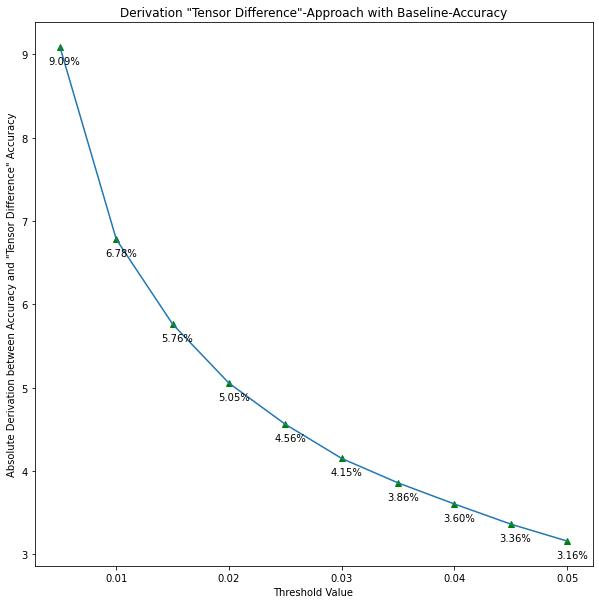

In [166]:

plt.figure(figsize=(10,10))
plt.xlabel('Threshold Value')
plt.ylabel('Absolute Derivation between Accuracy and "Tensor Difference" Accuracy')
plt.title('Derivation "Tensor Difference"-Predictions with Baseline-Accuracy')

for i in range(len(pert_ratio)):
    plt.annotate("{:.2f}%".format(99.20-pert_ratio[i]), (ep[i]-0.001,99.20-pert_ratio[i]-0.2))
plt.plot(ep, 99.20-pert_ratio, 'g^',ep,99.20-pert_ratio)

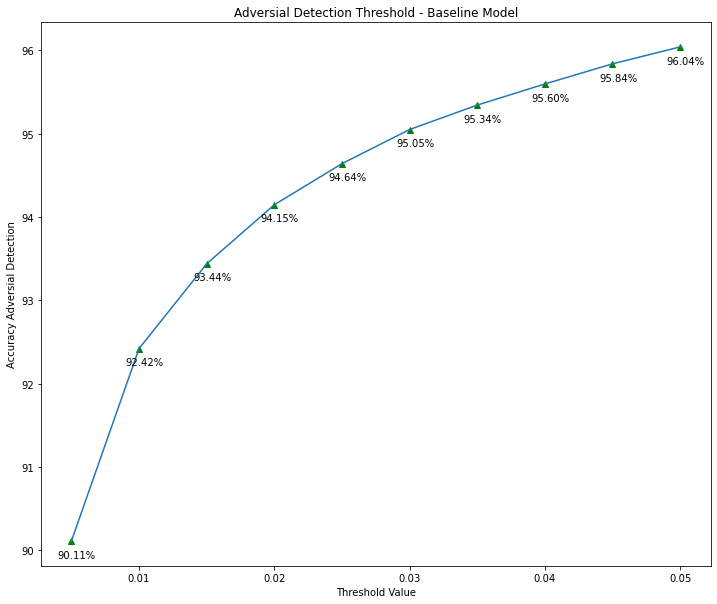

In [114]:

plt.figure(figsize=(12,10))
plt.xlabel('Threshold Value')
plt.ylabel('Accuracy Adversial Detection')
plt.title('Adversial Detection Threshold - Baseline Model')

for i in range(len(pert_ratio)):
    plt.annotate("{:.2f}%".format(pert_ratio[i]), (ep[i]-0.001,pert_ratio[i]-0.2))
plt.plot(ep, pert_ratio, 'g^',ep,pert_ratio)

In [12]:
#! Warning: Function is really slow because it generates new pertubations for each step

start=0.4
end=0.5
step=0.01
pert_count=0
epsilons = []
pertubation_ratio = []
accuracies_adversial = []
from foolbox.criteria import Misclassification
# load data from dataloader
while(start <= end):
  pertubated=0
  not_pertubated=0
  pert_count=0
  for i, data in enumerate(train_loader,0):
    input, label = data
    input, label = Variable(input.to(device)), Variable(label.to(device))

    model = network.eval()

      
      # Generate adversial dataset for attack
    fmodel = fb.PyTorchModel(model, bounds=(-0.4242129623889923, 2.821486711502075), device="cpu")
    attack = fb.attacks.FGSM()
    epsilons = [0.3] #, 0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0
    criterion = Misclassification(label)
    raw_advs, advs, is_adv = attack(fmodel, input, label, epsilons=epsilons)
    output = network(raw_advs[0])

        # Output median smoothed ensemble
    median_smoothed_batch=torch.clone(raw_advs[0])
    median_smoothed_batch = median_smoothing(median_smoothed_batch)
    output_ms = network(median_smoothed_batch)
        # Output bit reduced ensemble
    bit_reduced_batch=torch.clone(raw_advs[0])
    bit_reduced_batch = bit_reduction(bit_reduced_batch)
    output_br = network(bit_reduced_batch)
      
    pred = output.data.max(1, keepdim=True)[1]
    pred_ms = output_ms.data.max(1, keepdim=True)[1]
    pred_br = output_br.data.max(1, keepdim=True)[1]

    tensor_map_pred= F.softmax(output, dim=1)
    tensor_map_ms = F.softmax(output_ms, dim=1)
    tensor_map_br = F.softmax(output_br, dim=1)
      
    for x in range(len(pred)):
      difference_ms=abs((tensor_map_pred[x])-(tensor_map_ms[x]))
      difference_br=abs((tensor_map_pred[x])-(tensor_map_br[x]))
      distance_list=[max(difference_br).item(),max(difference_ms).item()]
          #difference_total = statistics.fmean(distance_list)
      difference_total = max(distance_list)
          #print("Max Tensor Distance:", difference_total)
      if (difference_total > start):
        pertubated+=1
            #print("Image is pertubated")
      else:
        not_pertubated+=1
            #print("Image is not pertubated")
    pert_count+=np.count_nonzero(is_adv.cpu().view(-1).numpy())
    accuracies_adversial.append(fb.utils.accuracy(fmodel, raw_advs[0], label))
  ratio=(100/pert_count)*pertubated
  epsilons.append(start)
  pertubation_ratio.append(ratio)
  
  print("Threshold {} with derivation of {}%".format(start,100-ratio))
  print("Accuracy attacked Baseline: ",np.array(accuracies_adversial).mean())
  print("Pertubated real: {}".format(pert_count))
  print("Pertubated calculated: {}".format(pertubated))
  print("Not Pertubated calculated: {}".format(not_pertubated))
  print("#############################################")
  start+=step

Threshold 0.4 with derivation of -10.366574694521091%
Accuracy attacked Baseline:  0.9154333333333333
Pertubated real: 5074
Pertubated calculated: 5600
Not Pertubated calculated: 54400
#############################################
Threshold 0.41000000000000003 with derivation of -7.50886874260938%
Accuracy attacked Baseline:  0.9154333333333333
Pertubated real: 5074
Pertubated calculated: 5455
Not Pertubated calculated: 54545
#############################################
Threshold 0.42000000000000004 with derivation of -4.197871501773747%
Accuracy attacked Baseline:  0.9154333333333333
Pertubated real: 5074
Pertubated calculated: 5287
Not Pertubated calculated: 54713
#############################################
Threshold 0.43000000000000005 with derivation of -1.1824990145841525%
Accuracy attacked Baseline:  0.9154333333333333
Pertubated real: 5074
Pertubated calculated: 5134
Not Pertubated calculated: 54866
#############################################
Threshold 0.44000000000000006 w

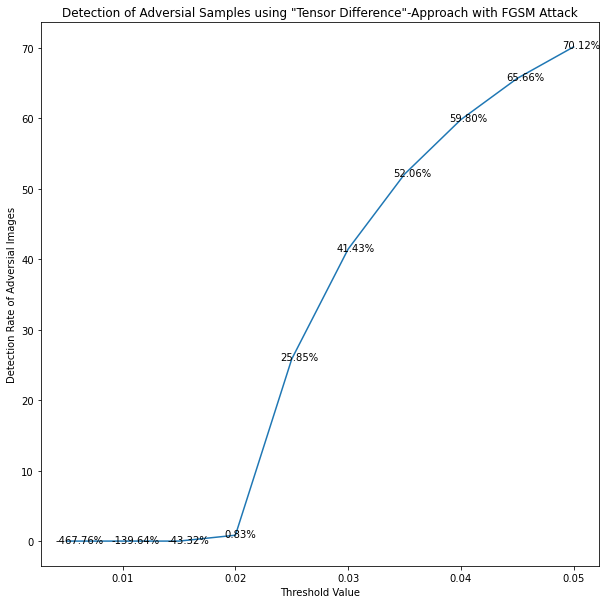

In [167]:
plt.figure(figsize=(10,10))
plt.xlabel('Threshold Value')
plt.ylabel('Detection Rate of Adversial Images')
plt.title('Detection of Adversial Samples using "Tensor Difference"-Approach with FGSM Attack')

for i in range(len(pertubation_ratio)):
    plt.annotate("{:.2f}%".format(100-pertubation_ratio[i]), (ep[i]-0.001,(100-np.array(pertubation_ratio[i])).clip(min=0)-0.2))
plt.plot(ep, (100-np.array(pertubation_ratio)).clip(min=0))

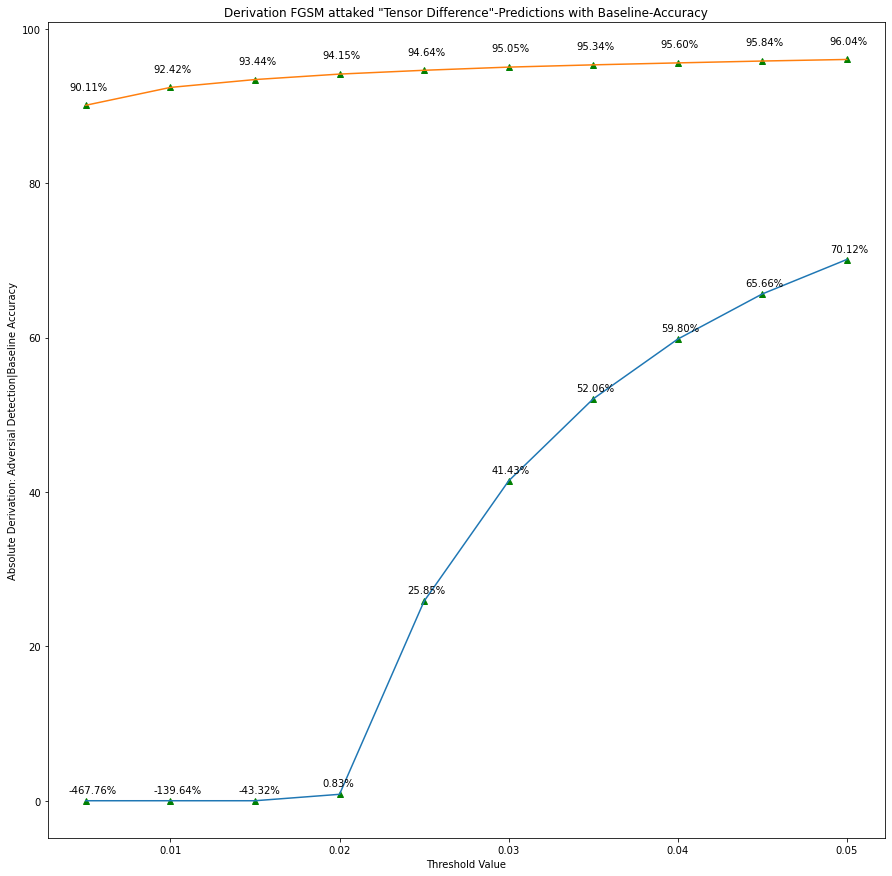

In [180]:
plt.figure(figsize=(15,15))
plt.xlabel('Threshold Value')
plt.ylabel('Absolute Derivation: Adversial Detection|Baseline Accuracy')
plt.title('Derivation FGSM attaked "Tensor Difference"-Predictions with Baseline-Accuracy')

for i in range(len(pertubation_ratio)):
    plt.annotate("{:.2f}%".format(100-pertubation_ratio[i]), (ep[i]-0.001,(100-np.array(pertubation_ratio[i])).clip(min=0)+1))
plt.plot(ep, (100-np.array(pertubation_ratio)).clip(min=0),'g^',ep, (100-np.array(pertubation_ratio)).clip(min=0))

for i in range(len(pert_ratio)):
    plt.annotate("{:.2f}%".format(pert_ratio[i]), (ep[i]-0.001,pert_ratio[i]+2))
plt.plot(ep, pert_ratio, 'g^',ep,pert_ratio)


In [9]:
def test(use_ensemble=0):
  test_losses=[]
  test_acc = []
  network.eval()
  if (use_ensemble==1 and use_integrated_ensemble==0):
    network2.eval()
    network3.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      if (use_ensemble==1 and use_integrated_ensemble==0):
        output2 = network2(data)
        output3 = network3(data)
        output = (output + output2 + output3)/3# Average of three networks. Alternative is to use majority voting using output.data.max(1)[1] for each output and write it to an array to get argmax

      test_loss += F.cross_entropy(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  acc = 100. * correct / len(test_loader.dataset)
  test_acc.append(acc)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return(acc)

In [9]:
test()


Test set: Avg. loss: 0.0007, Accuracy: 9920/10000 (99%)



tensor(99.2000)

In [197]:
def test_conv_image_rect(use_ensemble=1):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    test_acc = []
    debug_output = 1
    network.eval()
    network2.eval()
    network3.eval()
    test_loss = 0
    correct = 0
    correct_ms = 0
    correct_br = 0
    correct_ensemble = 0
    pertubated = 0
    not_pertubated = 0
    with torch.no_grad():
        for data, target in test_loader:

            # Output original ensemble
            output = network(data)
            output2 = network2(data)
            output3 = network3(data)

            # Output median smoothed ensemble
            median_smoothed_batch=torch.clone(data)
            median_smoothed_batch = median_smoothing(median_smoothed_batch)
            output_ms = network(median_smoothed_batch)
            output2_ms = network2(median_smoothed_batch)
            output3_ms = network3(median_smoothed_batch)
            # Output bit reduced ensemble
            bit_reduced_batch=torch.clone(data)
            bit_reduced_batch = bit_reduction(bit_reduced_batch)
            output_br = network(bit_reduced_batch)
            output2_br = network2(bit_reduced_batch)
            output3_br = network3(bit_reduced_batch)

            # Average of three networks. Alternative is to use majority voting using output.data.max(1)[1] for each output and write it to an array to get argmax
            output = (output + output2 + output3)/3
            output_ms = (output_ms + output2_ms + output3_ms)/3
            output_br = (output_br + output2_br + output3_br)/3

            # Losses for each ensemble
            test_loss += F.cross_entropy(output, target).item()
            # To
            # Do

            # Test accuracy

            pred = output.data.max(1, keepdim=True)[1]
            pred_ms = output_ms.data.max(1, keepdim=True)[1]
            pred_br = output_br.data.max(1, keepdim=True)[1]

            tst= F.softmax(output, dim=1)
            tst_med = F.softmax(output_ms, dim=1)
            tst_scaled = F.softmax(output_br, dim=1)



            # Jury Vote for ensemble predictions
            jury_vote = []
            for x in range(len(pred)):
                votes = []
                first_vote = output.data.max(1, keepdim=True)[1][x].item()
                second_vote = output_ms.data.max(1, keepdim=True)[1][x].item()
                third_vote = output_br.data.max(1, keepdim=True)[1][x].item()
                votes.append(first_vote)
                votes.append(second_vote)
                votes.append(third_vote)
                jury_vote.append(np.bincount(votes).argmax())
                difference_ms=(tst[x])-(tst_med[x])
                difference_br=(tst[x])-(tst_scaled[x])


                distance_list=[max(difference_br).item(),max(difference_ms).item()]
                #difference_total = statistics.fmean(distance_list)
                difference_total = max(distance_list)
                #print("Max Tensor Distance:", difference_total)

                if (difference_total > 0.015):
                    pertubated+=1
                    #print("Image is pertubated")
                else:
                    not_pertubated+=1
                    #print("Image is not pertubated")
                
                if(target[x].item()==jury_vote[x]):
                    correct_ensemble += 1
                else:
                    print("Original target:",target[x].item(),"| Jury voted class:",jury_vote[x],"| Vanilla Ensemble Vote:" ,first_vote,"Median-Smoothed Ensemble Vote:",second_vote,"Bit-Reduced Ensemble Vote:",third_vote)
                    if (debug_output):
                        fig = plt.figure()
                        ax1 = fig.add_subplot(131)  # left side
                        ax2 = fig.add_subplot(132)  # right side
                        ax3 = fig.add_subplot(133)  # right side
                    
                        ax1.title.set_text("Original Image")
                        ax2.title.set_text("Median Smoothed Image")
                        ax3.title.set_text("Bit Reduced Image")

                        ax1.imshow(data[x][0], cmap='gray', interpolation='none')
                        ax2.imshow(median_smoothed_batch[x][0], cmap='gray', interpolation='none')
                        ax3.imshow(bit_reduced_batch[x][0], cmap='gray', interpolation='none')
                        fig.text(.5, .05, "Original Target: {}".format(target[x].item()), ha='center')
                        fig.set_figheight(5)
                        fig.set_figwidth(10)
                        plt.show()


            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ms += pred_ms.eq(target.data.view_as(pred_ms)).sum()
            correct_br += pred_br.eq(target.data.view_as(pred_br)).sum()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_acc.append(acc)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Accuracy_Median: {}, Accuracy_BitSmooth: {}, Accuracy_Ensemble: {}, perturbated_count: {}, not_perturbated_count: {}\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset), correct_ms, correct_br, correct_ensemble, pertubated, not_pertubated))
    

In [198]:
test_conv_image_rect()

NameError: name 'network2' is not defined

In [178]:
#0.001, pert=1430,n_pert=8554
#0.002, pert=1114,n_pert=8870
#0.003, pert=961,n_pert=9023
#0.004, pert=865,n_pert=9119
#0.005, pert=803,n_pert=9181
#0.006, pert=752,n_pert=9232
#0.007, pert=710,n_pert=9274
#0.008, pert=667,n_pert=9317
#0.009, pert=627,n_pert=9357
#0.010, pert=608,n_pert=9376
#0.011, pert=586,n_pert=9398
#0.012, pert=569,n_pert=9415
#0.013, pert=552,n_pert=9432
#0.014, pert=536,n_pert=9448
#0.015, pert=515,n_pert=9469
#0.020, pert=461,n_pert=9523
#0.025, pert=432,n_pert=9552
#0.030, pert=400,n_pert=9584

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc = []

test()
for epoch in range(1, n_epochs + 1):
  train(epoch,adversial_train=1,dataset="MNIST")
  test()

if (use_upgraded_net==0 and save_net==1):
  torch.save(network.state_dict(), '../src/results/model.pth')
  torch.save(optimizer.state_dict(), '../src/results/optimizer.pth')
  print("Saved Modell to file")
elif (use_upgraded_net==1 and save_net==1):
  
  if (use_ensemble == 1 and use_integrated_ensemble == 0):
      torch.save(network.state_dict(), '../src/results/model_upgraded_ens.pth')
      torch.save(network2.state_dict(), '../src/results/model2_upgraded_ens.pth')
      torch.save(network3.state_dict(), '../src/results/model3_upgraded_ens.pth')
      torch.save(optimizer_ensemble.state_dict(), '../src/results/optimizer_ensemble.pth')
  if (use_ensemble == 1 and use_integrated_ensemble == 1):
      if  "cifar" in str(test_loader.dataset.filename):
        torch.save(network.state_dict(), '../src/results/model_integrated_ens_cifar.pth')
        torch.save(optimizer.state_dict(), '../src/results/optimizer_integrated_cifar.pth')
        print("Hello")
      else:
        torch.save(network.state_dict(), '../src/results/model_integrated_ens.pth')
        torch.save(optimizer.state_dict(), '../src/results/optimizer_integrated.pth')

  if (use_ensemble==0 and use_integrated_ensemble == 0):
      torch.save(network.state_dict(), '../src/results/model_upgraded.pth')
      torch.save(optimizer.state_dict(), '../src/results/optimizer_upgraded.pth')
  print("Saved Modell to file")
save_net = 0 #Secure that only one model is saved


Test set: Avg. loss: 0.0009, Accuracy: 9892/10000 (99%)

Train Epoch: 1 [5984/60000 (10%)]	Loss: 0.285587
Train Epoch: 1 [11968/60000 (20%)]	Loss: 0.015238
Train Epoch: 1 [17952/60000 (30%)]	Loss: 0.245951
Train Epoch: 1 [23936/60000 (40%)]	Loss: 0.111439
Train Epoch: 1 [29920/60000 (50%)]	Loss: 0.256799
Train Epoch: 1 [35904/60000 (60%)]	Loss: 0.242399
Train Epoch: 1 [41888/60000 (70%)]	Loss: 0.136630
Train Epoch: 1 [47872/60000 (80%)]	Loss: 0.108147
Train Epoch: 1 [53856/60000 (90%)]	Loss: 0.072000
Train Epoch: 1 [59840/60000 (100%)]	Loss: 0.211496

Test set: Avg. loss: 0.0009, Accuracy: 9900/10000 (99%)

Train Epoch: 2 [5984/60000 (10%)]	Loss: 0.156696
Train Epoch: 2 [11968/60000 (20%)]	Loss: 0.149578
Train Epoch: 2 [17952/60000 (30%)]	Loss: 0.175112
Train Epoch: 2 [23936/60000 (40%)]	Loss: 0.085480
Train Epoch: 2 [29920/60000 (50%)]	Loss: 0.072918
Train Epoch: 2 [35904/60000 (60%)]	Loss: 0.124660
Train Epoch: 2 [41888/60000 (70%)]	Loss: 0.100030
Train Epoch: 2 [47872/60000 (80%)]	

In [ ]:
torch.save(network.state_dict(), '../src/results/model_integrated_ens_adv_mnist_03_n.pth')
torch.save(optimizer.state_dict(), '../src/results/optimizer_integrated_adv_mnist_03_n.pth')

In [34]:
torch.save(network.state_dict(), '../src/results/model_integrated_ens_adv_cifar.pth')
torch.save(optimizer.state_dict(), '../src/results/optimizer_integrated_adv_cifar.pth')

In [11]:
test()


Test set: Avg. loss: 0.0009, Accuracy: 9892/10000 (99%)



tensor(98.9200)

# Evaluate Baseline

In [10]:
def calculate_threshold_baseline (differences,misclassified=0,threshold_fp_percent=0,start=0.00001,end=1) -> float:
    max_fp = len(differences)*(threshold_fp_percent/100)
    # 500
    while (start <= end):
        fp = np.count_nonzero(differences[differences>start])
        if (fp == misclassified):
            return start,fp,(len(differences)-fp)
        start += 0.00001
    return (1)

    

In [11]:
def calculate_threshold_adversarial(differences_test,adversarial_map,correction_t=1.0,print_output=True,is_evaluate=False,t=None,is_paper=False) -> float:
    difference_map = zip(differences_test,adversarial_map)
    adversarial_distances = []
    non_adversarial_distances = []
    for x in range (len(adversarial_map)):
        if (adversarial_map[x]==1):
            adversarial_distances.append(differences_test[x])
        if (adversarial_map[x]==0):
            non_adversarial_distances.append(differences_test[x])
    
    print(max(adversarial_distances))
    print(min(adversarial_distances))
    print(np.array(adversarial_distances).mean())
    print("##########")
    print(max(non_adversarial_distances))
    print(min(non_adversarial_distances))
    print(np.array(non_adversarial_distances).mean())
    #t=(min(adversarial_distances)+max(non_adversarial_distances))/2
    t_distance=(min(adversarial_distances)+max(non_adversarial_distances))/2
    t_legitimate_mean=np.array(non_adversarial_distances).mean()
    t_adaptive=(t_distance+t_legitimate_mean)/2
    print("Distance t legitimate mean:",t_legitimate_mean)
    print("Distance t min-max:",t_distance)
    print("Distance t conservative mean:",t_adaptive)
    # Should t be more conservative or aggressive. Higher t means more conservative, resulting in less True Positives but less False Positives. True Negative Detection is rising with higher t and falling True Positive

    non_adversarial_distances=np.array(non_adversarial_distances)
    adversarial_distances=np.array(adversarial_distances)
    # Measure Quality of the three t_calc Models
    true_t_distance = np.count_nonzero(non_adversarial_distances[non_adversarial_distances<=t_distance])+np.count_nonzero(adversarial_distances[adversarial_distances>=t_distance])
    false_t_distance = np.count_nonzero(non_adversarial_distances[non_adversarial_distances>=t_distance])+np.count_nonzero(adversarial_distances[adversarial_distances<=t_distance])
    true_t_adaptive = np.count_nonzero(non_adversarial_distances[non_adversarial_distances<=t_adaptive])+np.count_nonzero(adversarial_distances[adversarial_distances>=t_adaptive])
    false_t_adaptive = np.count_nonzero(non_adversarial_distances[non_adversarial_distances>=t_adaptive])+np.count_nonzero(adversarial_distances[adversarial_distances<=t_adaptive])
    true_t_legitimate_mean = np.count_nonzero(non_adversarial_distances[non_adversarial_distances<=t_legitimate_mean])+np.count_nonzero(adversarial_distances[adversarial_distances>=t_legitimate_mean])
    false_t_legitimate_mean = np.count_nonzero(non_adversarial_distances[non_adversarial_distances>=t_legitimate_mean])+np.count_nonzero(adversarial_distances[adversarial_distances<=t_legitimate_mean])
    score_peak_distance = true_t_distance-false_t_distance
    score_adaptive = true_t_adaptive-false_t_adaptive
    score_legitimate_mean = true_t_legitimate_mean-false_t_legitimate_mean
    max_score = max(score_peak_distance,score_adaptive,score_legitimate_mean)
    min_score = min(score_peak_distance,score_adaptive,score_legitimate_mean)
    print("Score legitimate mean:",score_legitimate_mean)
    print("Score min-max:",score_peak_distance)
    print("Score conservative mean:",score_adaptive)
    print("##########")
    print("Max Score:",max_score)
    print("Min Score:",min_score)
    print("Mean Score:",(score_peak_distance+score_adaptive+score_legitimate_mean)/3)
    print("##########")
    if (score_peak_distance==max_score):
        print ("Evaluated peak distance calculation as best threshold for t")
        t=t_distance
    if (score_adaptive==max_score):
        print ("Evaluated adaptive calculation as best threshold for t")
        t=t_adaptive
    if (score_legitimate_mean==max_score):
        print ("Evaluated legitimate mean calculation as best threshold for t")
        t=t_legitimate_mean
    print("True T Distance: ",true_t_distance-false_t_distance)
    print("True T Adaptive: ",true_t_adaptive-false_t_adaptive)
    print("True T Legitimate Mean: ",true_t_legitimate_mean-false_t_legitimate_mean)
    print("Detection Ratio True T Distance: ",(100/len(adversarial_distances))*true_t_distance-false_t_distance)
    print("Detection Ratio False T Distance: ",(100/len(adversarial_distances))*false_t_distance)

    print("Detection Ratio True T Adaptive: ",(100/len(adversarial_distances))*true_t_adaptive-false_t_adaptive)
    print("Detection Ratio False T Adaptive: ",(100/len(adversarial_distances))*false_t_adaptive)

    print("Detection Ratio True T Mean: ",(100/len(adversarial_distances))*true_t_legitimate_mean-false_t_legitimate_mean)
    print("Detection Ratio False T Mean: ",(100/len(adversarial_distances))*false_t_legitimate_mean)
    
    if (print_output):
        limit=max(len(adversarial_distances),len(non_adversarial_distances))
        plt.figure(figsize=(30,10))
        plt.hlines(y=t,xmin=0,xmax=limit,color='green',linestyle='dashed')
        plt.plot(adversarial_distances)
        plt.plot(non_adversarial_distances,c="red")
        plt.legend(["Adversarial","Legitimate"])
        plt.grid()
        plt.show()
        #plt.plot(np.sort(adversarial_distances),np.sort(non_adversarial_distances))
    #plt.plot(np.sort(non_adversarial_distances))
    print(t)
    print("Legitimate Samples ",len(non_adversarial_distances))
    print("Adversarial Samples ",len(adversarial_distances))
    print("True Negatives ",np.count_nonzero(non_adversarial_distances[non_adversarial_distances<=t]))
    print("False Positives ",np.count_nonzero(non_adversarial_distances[non_adversarial_distances>=t]))
    print("True Positives ",np.count_nonzero(adversarial_distances[adversarial_distances>=t]))
    print("False Negatives",np.count_nonzero(adversarial_distances[adversarial_distances<=t]))
    print("##########")
    print("Detection Ratio TP: ",(100/len(adversarial_distances))*np.count_nonzero(adversarial_distances[adversarial_distances>=t]))
    print("Detection Ratio FN: ",(100/len(adversarial_distances))*np.count_nonzero(adversarial_distances[adversarial_distances<=t]))
    print("Detection Ratio TN: ",(100/len(non_adversarial_distances))*np.count_nonzero(non_adversarial_distances[non_adversarial_distances<=t]))
    print("Detection Ratio FP: ",(100/len(non_adversarial_distances))*np.count_nonzero(non_adversarial_distances[non_adversarial_distances>=t]))
    return t

In [11]:
def evaluate_baseline(loader,network,is_attack=False,attack=None,epsilon=None,t=[0.0],median_kernel=2) -> float:
    import foolbox as fb
    from torch.autograd import Variable
    import time
    train_losses = []
    runs=0
    train_counter = []
    test_losses = []
    test_counter = [i*len(loader.dataset) for i in range(n_epochs + 1)]
    test_acc = []
    debug_output = 0
    test_loss = 0
    correct = 0
    correct_ms = 0
    correct_pool = 0
    correct_br = 0
    correct_ensemble = 0
    pertubated = 0
    pertubated_detected = 0
    differences=[]
    distance_l0 = 0
    distance_l1 = 0
    distance_l2 = 0
    distance_linf = 0
    adversarial_map = []
    base_accuracy = test()

    baseline_threshold = 0
    false_positives = 0
    true_negatives = 0

    if (is_attack):
        print("Attack Mode!")
        model = network.eval()
        time.sleep(1)
        if  "MNIST" in str(loader.dataset):
            fmodel = fb.PyTorchModel(model, bounds=(-0.4242129623889923, 2.821486711502075), device="cpu")
        else:
            fmodel = fb.PyTorchModel(model, bounds=(-1.989473819732666, 2.130864143371582), device="cpu")
    
    for i, data in enumerate(loader,0):
        input, target = data
        input, target = Variable(input.to(device)), Variable(target.to(device))
        if (is_attack):
            raw_advs, advs, is_adv = attack(fmodel, input, target, epsilons=epsilon)
            data = advs[0]
            pertubated += np.count_nonzero(is_adv.cpu().view(-1).numpy())
            adversarial_map.append(is_adv[0].numpy().astype(int))
            # Output original ensemble
        else:
            data = input
        with torch.no_grad():
            output = network(data)

            # Output median smoothed ensemble
            median_smoothed_batch=torch.clone(data)
            median_smoothed_batch = median_smoothing(median_smoothed_batch,kernel_size=median_kernel)
            output_ms = network(median_smoothed_batch)

            # Output bit reduced ensemble
            bit_reduced_batch=torch.clone(data)
            bit_reduced_batch = bit_reduction(bit_reduced_batch, bit=1) #CIFAR = 4
            output_br = network(bit_reduced_batch)

            # Losses for each ensemble
            test_loss += F.cross_entropy(output, target).item()

            # Test accuracy
            pred = output.data.max(1, keepdim=True)[1]
            pred_ms = output_ms.data.max(1, keepdim=True)[1]
            pred_br = output_br.data.max(1, keepdim=True)[1]

            output_ens = (output + output_ms + output_br)/3# Average of three networks. Alternative is to use majority voting using output.data.max(1)[1] for each output and write it to an array to get argmax
            pred_ens = output_ens.data.max(1, keepdim=True)[1]

            softmax_baseline= F.softmax(output, dim=1)
            softmax_median_smooth = F.softmax(output_ms, dim=1)
            softmax_bitreduction = F.softmax(output_br, dim=1)
            

            # Jury Vote for ensemble predictions
            jury_vote = []
            for x in range(len(pred)):
                votes = []
                first_vote = output.data.max(1, keepdim=True)[1][x].item()
                second_vote = output_ms.data.max(1, keepdim=True)[1][x].item()
                third_vote = output_br.data.max(1, keepdim=True)[1][x].item()
                votes.append(first_vote)
                votes.append(second_vote)
                votes.append(third_vote)
                jury_vote.append(np.bincount(votes).argmax())

            # Calculate distance between baseline and rectificated softmax outputs
                difference_ms=abs((softmax_baseline[x])-(softmax_median_smooth[x]))
                difference_br=abs((softmax_baseline[x])-(softmax_bitreduction[x]))


                distance_list=[max(difference_br).item(),max(difference_ms).item()]
                #difference_total = statistics.fmean(distance_list)
                difference_total = max(distance_list)
                #print("Max Tensor Distance:", difference_total)
                differences.append(difference_total)
                if (is_attack):
                    if ((difference_total > t) and ((is_adv[0].numpy().astype(int))[x] == 1)):
                            pertubated_detected += 1

                if(target[x].item()==jury_vote[x]):
                    correct_ensemble += 1
                else:
                    #print("Original target:",target[x].item(),"| Jury voted class:",jury_vote[x],"| Vanilla Ensemble Vote:" ,first_vote,"Median-Smoothed Ensemble Vote:",second_vote,"Bit-Reduced Ensemble Vote:",third_vote)
                    if (debug_output):
                        fig = plt.figure()
                        ax1 = fig.add_subplot(131)  # left side
                        ax2 = fig.add_subplot(132)  # right side
                        ax3 = fig.add_subplot(133)  # right side
                    
                        ax1.title.set_text("Original Image")
                        ax2.title.set_text("Median Smoothed Image")
                        ax3.title.set_text("Bit Reduced Image")

                        ax1.imshow(data[x][0], cmap='gray', interpolation='none')
                        ax2.imshow(median_smoothed_batch[x][0], cmap='gray', interpolation='none')
                        ax3.imshow(bit_reduced_batch[x][0], cmap='gray', interpolation='none')
                        fig.text(.5, .05, "Original Target: {}".format(target[x].item()), ha='center')
                        fig.set_figheight(5)
                        fig.set_figwidth(10)
                        plt.show()


            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ms += pred_ms.eq(target.data.view_as(pred_ms)).sum()
            correct_br += pred_br.eq(target.data.view_as(pred_br)).sum()
            correct_pool += pred_ens.eq(target.data.view_as(pred_ens)).sum()
            if (is_attack):
                distance_l0 += (fb.distances.l0(raw_advs[0], input)/32).mean().item()
                distance_l1 += (fb.distances.l0(advs[0], input)/32).mean().item()
                distance_l2 += (fb.distances.l2(raw_advs[0], input)/32).mean().item()
                distance_linf += (fb.distances.linf(raw_advs[0]/32, input)).mean().item()
            runs+=1
            
    test_loss /= len(loader.dataset)
    test_losses.append(test_loss)
    acc = 100. * correct / len(loader.dataset)
    test_acc.append(acc)
    if not (is_attack):
        baseline_threshold,false_positives,true_negatives=calculate_threshold_baseline(np.array(differences),pertubated)
    print('\nTest set: Avg. loss baseline: {:.4f}, Accuracy: {}/{} ({:.0f}%), Accuracy_Median_Smooth: {}, Accuracy_Bit_Reduction: {}, Accuracy_Jury_Ensemble: {}, Accuracy_Pooled_Ensemble: {}, Threshold t Baseline: {}, False Positives Baseline: {}, True Negatives Baseline: {}, Pertubated Samples Detected: {}, Pertubated Samples Real: {}\n'.format(
    test_loss, acc, len(loader.dataset),
    100. * correct / len(loader.dataset), 100. * correct_ms / len(loader.dataset), 100. * correct_br / len(loader.dataset), 100. * correct_ensemble / len(loader.dataset),100. * correct_pool / len(loader.dataset),baseline_threshold,false_positives,true_negatives, pertubated_detected, pertubated))
    print('Attack Success (Pooled): {}'.format((100-(100/base_accuracy)-acc)/100))
    if (is_attack):
        print('\nDetection Accuracy {}%'.format((100/pertubated)*pertubated_detected))
    print('L0 Distance: {}'.format(distance_l0/runs))
    print('L2 Distance: {}'.format(distance_l2/runs))
    print('Linf Distance: {}'.format(distance_linf/runs))
    return(differences,np.array(adversarial_map).flatten())
    

In [12]:
differences_test,adversarial_map=evaluate_baseline(train_loader,network)
#calculate_threshold_adversarial(differences_test,adversarial_map,correction_t=1.0,print_output=False)

NameError: name 'evaluate_baseline' is not defined

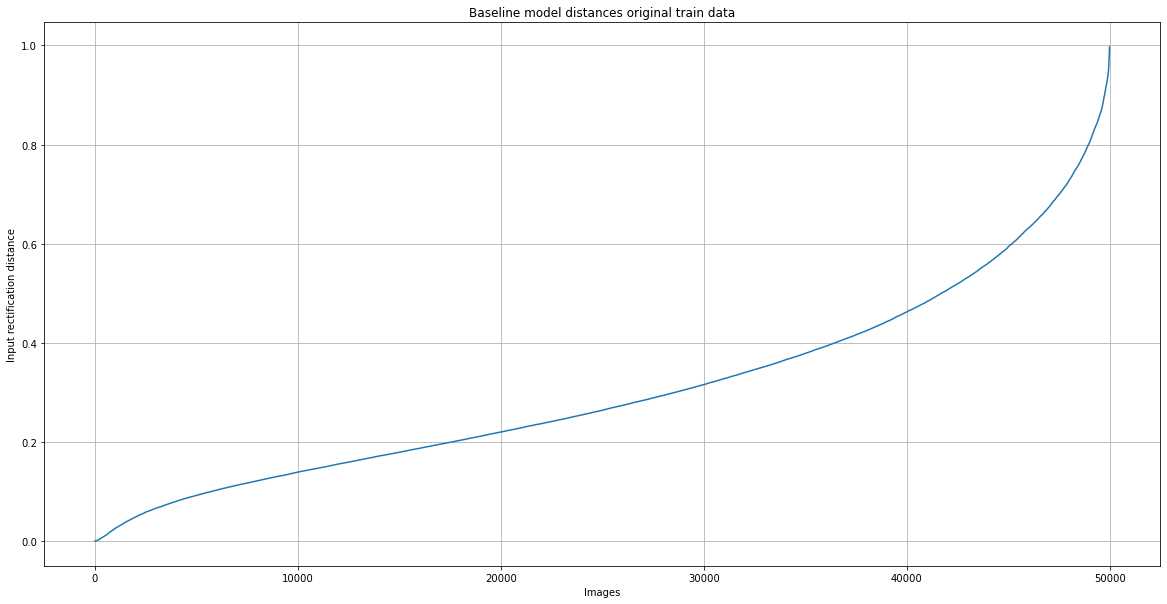

In [15]:
# Train Loader
plt.figure(figsize=(20,10))
plt.plot(np.sort(differences_test))
plt.title("Baseline model distances original train data")
plt.xlabel("Images")
plt.ylabel("Input rectification distance")
plt.grid()

In [20]:
print(np.max(differences_test))
print(np.min(differences_test))
print(np.mean(differences_test))

0.996910810470581
1.430511474609375e-06
0.30630544888440436


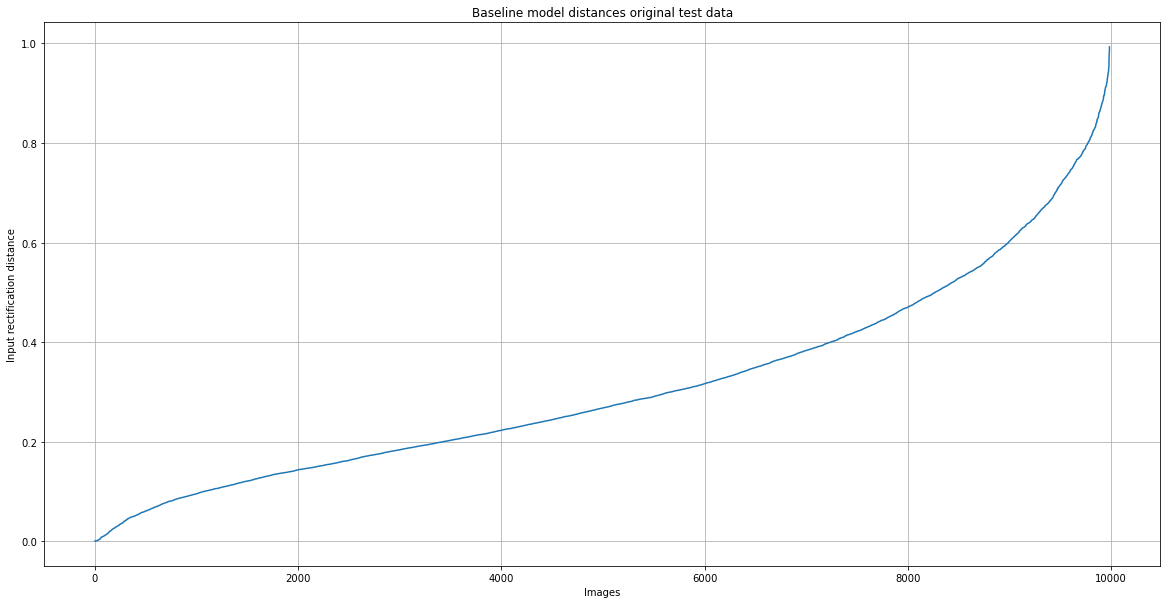

In [17]:
# Test Loader
plt.figure(figsize=(20,10))
plt.plot(np.sort(differences_test))
plt.title("Baseline model distances original test data")
plt.xlabel("Images")
plt.ylabel("Input rectification distance")
plt.grid()

In [18]:
print(np.max(differences_test))
print(np.min(differences_test))
print(np.mean(differences_test))

0.9931092858314514
1.7523765563964844e-05
0.31005992540429783


In [28]:
print("Attacking Train Loader for estimating optimal threshold value t")
print("##############################################################################")
print("##############################################################################")
print("##############################################################################")

differences_test,adversarial_map=evaluate_baseline(train_loader,network,is_attack=True,attack=fb.attacks.FGSM(),epsilon=[0.1],t=1.0)
print("Choosing t-calculating strategy for optimal value t")
print("##############################################################################")
print("##############################################################################")
print("##############################################################################")
t=calculate_threshold_adversarial(differences_test,adversarial_map,correction_t=1.0,print_output=True)

print("Attacking Test Loader with estimated threshold value t")
print("##############################################################################")
print("##############################################################################")
print("##############################################################################")
differences_test,adversarial_map=evaluate_baseline(test_loader,network,is_attack=True,attack=fb.attacks.FGSM(),epsilon=[0.1],t=t)

Attacking Train Loader for estimating optimal threshold value t
##############################################################################
##############################################################################
##############################################################################

Test set: Avg. loss: 0.0007, Accuracy: 9921/10000 (99%)

Attack Mode!


KeyboardInterrupt: 

0.9999460577964783
8.114402483272443e-09
0.43239533577457395
##########
0.9958803057670593
8.821487426757812e-06
0.36537019806216436
Max Score: 1366
Min Score: -1070
Mean Score: 174.0
##########
Evaluated legitimate mean calculation as best threshold for t
True T Distance:  -1070
True T Adaptive:  226
True T Legitimate Mean:  1366
Detection Ratio True T Distance:  -5477.189986589182
Detection Ratio False T Distance:  61.7679928475637
Detection Ratio True T Adaptive:  -4821.948144836835
Detection Ratio False T Adaptive:  54.52615109521681
Detection Ratio True T Mean:  -4245.578006258382
Detection Ratio False T Mean:  48.156012516763525


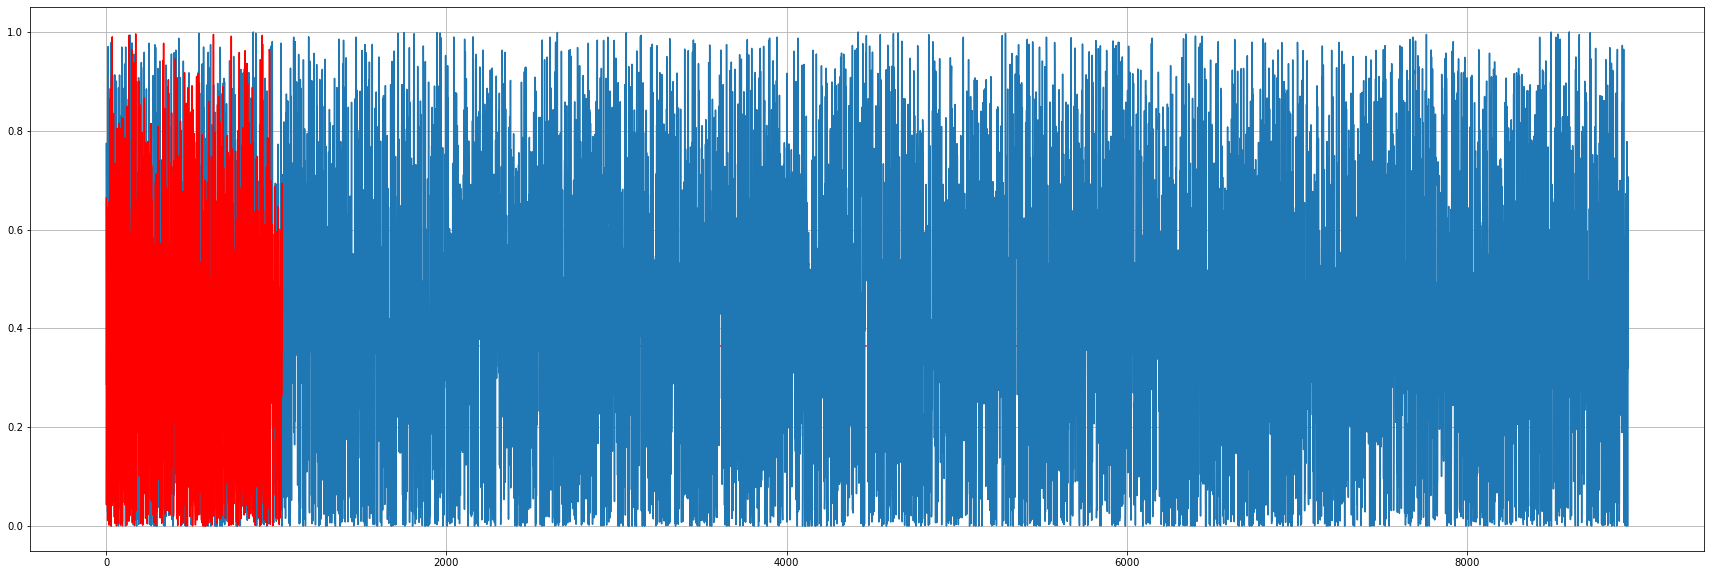

0.36537019806216436
Legitimate Samples  1036
Adversarial Samples  8948
True Negatives  541
False Positives  495
True Positives  5134
False Negatives 3814
##########
Detection Ratio TP:  57.37594993294591
Detection Ratio FN:  42.62405006705409
Detection Ratio TN:  52.22007722007722
Detection Ratio FP:  47.77992277992278


0.36537019806216436

In [671]:
calculate_threshold_adversarial(differences_test,adversarial_map,correction_t=1.0,print_output=True,is_attack=True)

In [13]:
differences_test,adversarial_map=evaluate_baseline(test_loader,network,is_attack=True,attack=fb.attacks.FGSM(),epsilon=[1],t=0,median_kernel=3)


Test set: Avg. loss: 0.0006, Accuracy: 9924/10000 (99%)

Attack Mode!

Test set: Avg. loss baseline: 0.0567, Accuracy: 62.68000030517578/10000 (63%), Accuracy_Median_Smooth: 61.36000061035156, Accuracy_Bit_Reduction: 91.16999816894531, Accuracy_Jury_Ensemble: 68.09, Accuracy_Pooled_Ensemble: 81.19999694824219, Threshold t Baseline: 0, False Positives Baseline: 0, True Negatives Baseline: 0, Pertubated Samples Detected: 3716, Pertubated Samples Real: 3716

Attack Success (Pooled): 0.3631233870983124

Detection Accuracy 100.0%
L0 Distance: 13.817639473157051
L2 Distance: 0.6160080287701044
Linf Distance: 2.756987167474551


In [81]:
network.load_state_dict(torch.load('../src/results/model_integrated_ens_cifar.pth'))
print('Loaded integrated adversarial trained ensemble model for cifar from file')
optimizer.load_state_dict(torch.load('../src/results/optimizer_integrated_cifar.pth'))
print('Loaded adversarial trained optimizer from integrated ensemble model for cifar')

Loaded integrated adversarial trained ensemble model for cifar from file
Loaded adversarial trained optimizer from integrated ensemble model for cifar


# Paper related evaluation method

In [13]:
def generate_pertubated_examples(n=100,attack_method=None,epsilon=[0.1],datatype="MNIST"):
    device = torch.device("cpu")
    adversial_data = []
    legitimate_data = []
    legitimate_label = []
    adversial_orignal_labels = []
    collected_ad=0
    collected_leg=0
    model = network.eval()
    print(epsilon)
    for i, data in enumerate(test_loader,0):
         
        input, label = data
        input, label = Variable(input.to(device)), Variable(label.to(device))
            # Generate adversial dataset for attack
        if (datatype=="CIFAR"):
            fmodel = fb.PyTorchModel(model, bounds=(-1.989473819732666, 2.130864143371582), device="cpu") #CIFAR
        else:
            fmodel = fb.PyTorchModel(model, bounds=(-0.4242129623889923, 2.821486711502075), device="cpu") #MNIST
        attack = attack_method
            #attack = fb.attacks.L2CarliniWagnerAttack()
        epsilons = epsilon #, 0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0

        raw_advs, advs, is_adv = attack(fmodel, input, label, epsilons=epsilons)
        adversarial_indexes = np.where((is_adv[0].cpu().view(-1).numpy()).astype(int)==1)
        legitimate_indexes = np.where((is_adv[0].cpu().view(-1).numpy()).astype(int)==0)
        #print (adversarial_indexes)
        for adversarials in range(len(adversarial_indexes[0])):
            if collected_ad==n:
                break
            #print(adversarials)
            adversial_orignal_labels.append(label[adversarial_indexes[0][adversarials]])
            adversial_data.append(advs[0][adversarial_indexes[0][adversarials]])
            collected_ad+=1
        for legitimates in range(len(legitimate_indexes[0])):
            if collected_leg==n:
                break
            legitimate_label.append(label[legitimate_indexes[0][legitimates]])
            legitimate_data.append(input[legitimate_indexes[0][legitimates]])
            collected_leg+=1
        if (collected_leg==n and collected_ad==n):
            break
    if(collected_leg!=n):
        print("Not enough legitimate samples")
    if(collected_ad!=n):
        print("Not enough adversarial samples")
    
    print(adversial_data[0].shape)
    if (datatype=="CIFAR"):
        return (adversial_data,torch.from_numpy(np.array(adversial_orignal_labels)),legitimate_data,torch.from_numpy(np.array(legitimate_label)))
    else:
        return (torch.cat(adversial_data).unsqueeze(dim=1),torch.from_numpy(np.array(adversial_orignal_labels)),torch.cat(legitimate_data).unsqueeze(dim=1),torch.from_numpy(np.array(legitimate_label)))   #dim1 = mnist

In [17]:
def calculate_mnist (attack_method,epsilon):
    print("#######################")
    print("#######################")
    print("#######################")
    print(attack_method)
    ad_data,ad_label,original_data,original_label = generate_pertubated_examples(n=200,attack_method=attack_method,epsilon=epsilon,datatype="MNIST") #unten
    cut = int(min(len(ad_data),len(original_data))/2)
    print("Train/Test split after {} samples".format(cut))
    data_train = torch.cat((ad_data[0:cut],original_data[0:cut]),dim=0) #! MNIST, CIFAR deactivate line
    label_train = torch.cat((ad_label[0:cut],ad_label[0:cut]),dim=0)

    if (len(ad_data)<=len(original_data)):
        data_test = torch.cat((ad_data[cut:len(ad_data)],original_data[cut:len(ad_data)]),dim=0) #! MNIST
        label_test = torch.cat((ad_label[cut:len(ad_data)],ad_label[cut:len(ad_data)]),dim=0)
    else:
        data_test = torch.cat((ad_data[cut:len(original_data)],original_data[cut:len(original_data)]),dim=0) #! MNIST
        label_test = torch.cat((ad_label[cut:len(original_data)],ad_label[cut:len(original_data)]),dim=0)
    differences,adversarial_map=evaluation_paper(data_train,label_train,network=network,datatype="MNIST")
    t_value=calculate_threshold_adversarial(differences,adversarial_map,correction_t=1.0,print_output=True)
    differences=evaluation_paper(data_test,label_test,network,t_value,evaluate=True,datatype="MNIST")
# CIFAR

#######################
#######################
#######################
LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
[0.1]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 58 samples
Calculated train dataset distances
0.666170060634613
0.004288733005523682
0.22882973466967715
##########
0.1598527431488037
1.4074332810309897e-08
0.008045392893454495
Distance t legitimate mean: 0.008045392893454495
Distance t min-max: 0.0820707380771637
Distance t conservative mean: 0.04505806548530909
Score legitimate mean: 98
Score min-max: 82
Score conservative mean: 90
##########
Max Score: 98
Min Score: 82
Mean Score: 90.0
##########
Evaluated legitimate mean calculation as best threshold for t
True T Distance:  82
True T Adaptive:  90
True T Legitimate Mean:  98
Detection Ratio True T Distance:  153.68965517241378
Detection Ratio False T Distance:  29.310344827586206
Detection Ratio True T Adaptive:  164.58620689655172
Detecti

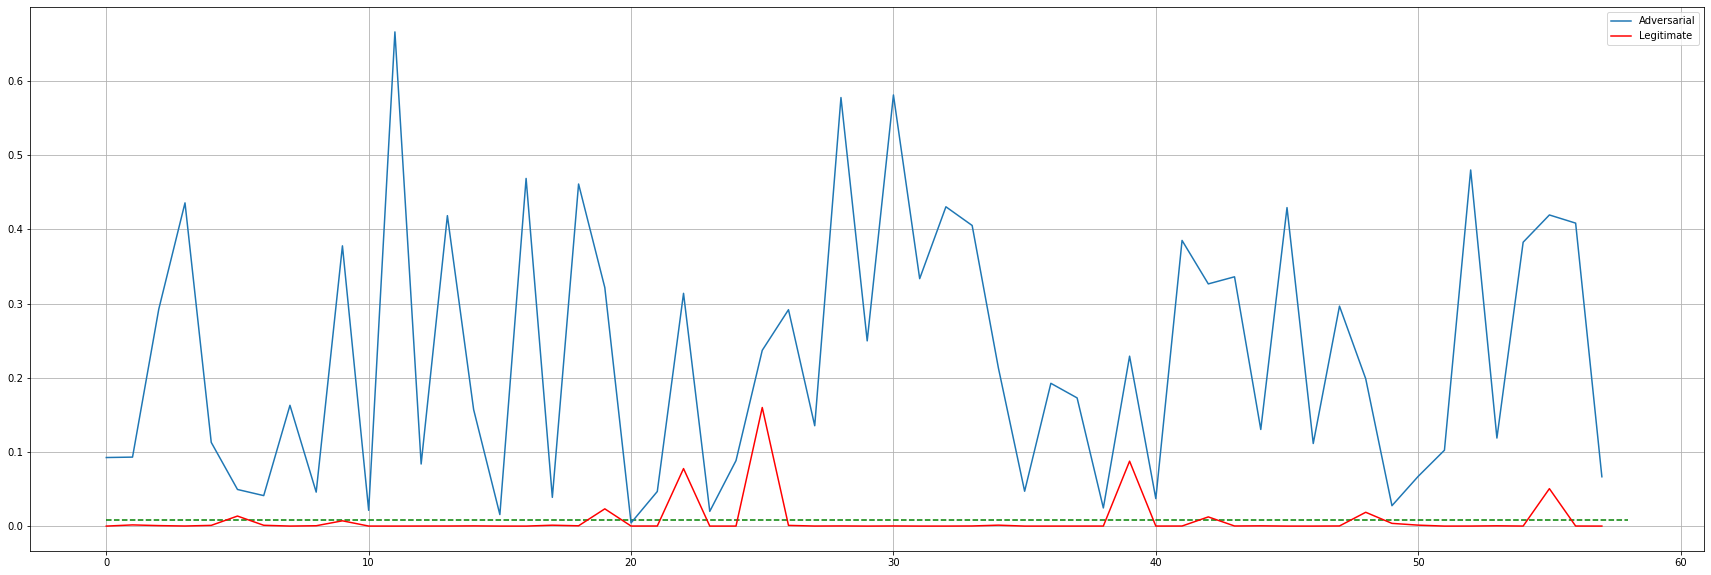

0.008045392893454495
Legitimate Samples  58
Adversarial Samples  58
True Negatives  50
False Positives  8
True Positives  57
False Negatives 1
##########
Detection Ratio TP:  98.27586206896551
Detection Ratio FN:  1.7241379310344827
Detection Ratio TN:  86.20689655172413
Detection Ratio FP:  13.793103448275861
True Positives: 56
False Positives: 9
True Negatives: 49
False Negatives: 2
Accuracy: 0.9051724137931034
#######################
#######################
#######################
LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
[0.5]
torch.Size([1, 28, 28])
Train/Test split after 100 samples
Calculated train dataset distances
0.8517032861709595
0.002433180809020996
0.3866310129314661
##########
0.8041393160820007
8.898976666671388e-09
0.014243679147224854
Distance t legitimate mean: 0.014243679147224854
Distance t min-max: 0.40328624844551086
Distance t conservative mean: 0.20876496379636786
Score legitimate mean: 186
Score min-max: 100
Score

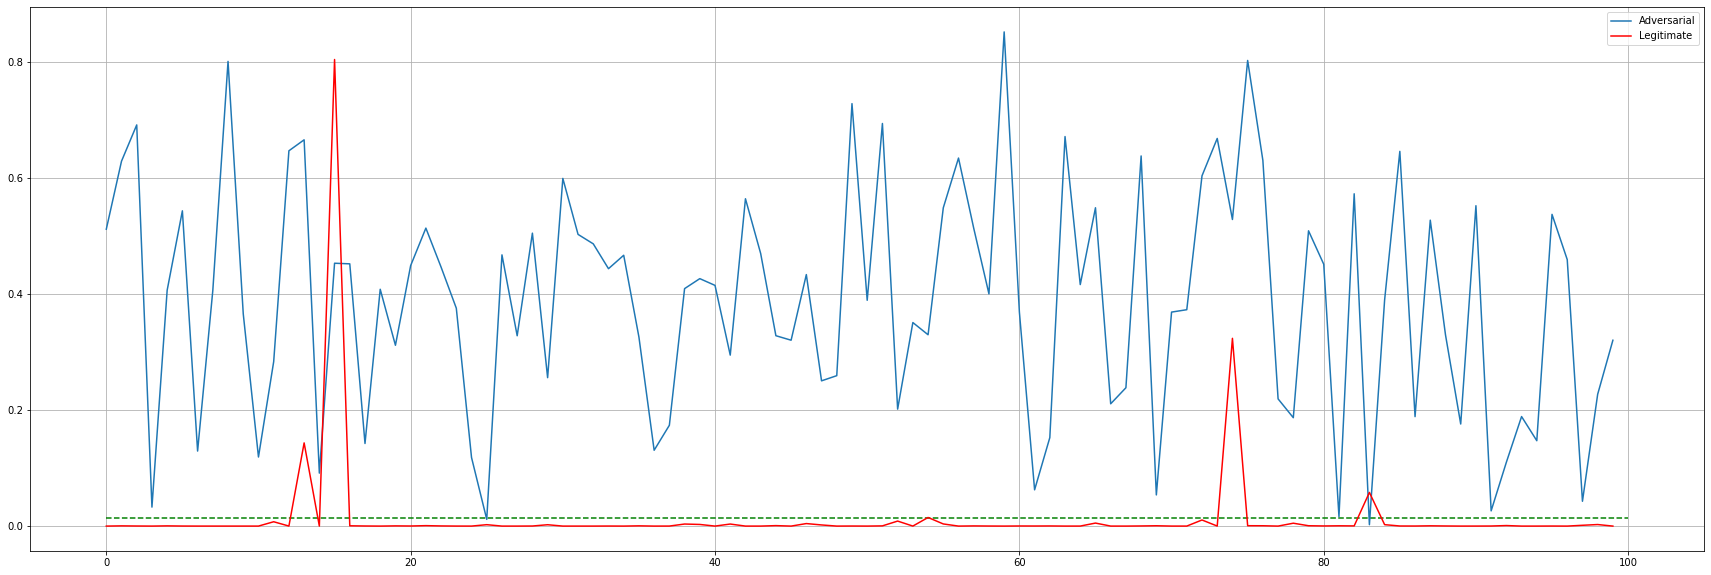

0.014243679147224854
Legitimate Samples  100
Adversarial Samples  100
True Negatives  95
False Positives  5
True Positives  98
False Negatives 2
##########
Detection Ratio TP:  98.0
Detection Ratio FN:  2.0
Detection Ratio TN:  95.0
Detection Ratio FP:  5.0
True Positives: 98
False Positives: 4
True Negatives: 96
False Negatives: 2
Accuracy: 0.97
#######################
#######################
#######################
LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
[1]
torch.Size([1, 28, 28])
Train/Test split after 100 samples
Calculated train dataset distances
0.9341682195663452
0.017731374129652977
0.5461570609174669
##########
0.0029953718185424805
3.4299382889457775e-08
0.00021283281379233187
Distance t legitimate mean: 0.00021283281379233187
Distance t min-max: 0.010363372974097729
Distance t conservative mean: 0.00528810289394503
Score legitimate mean: 150
Score min-max: 200
Score conservative mean: 200
##########
Max Score: 200
Min Score: 

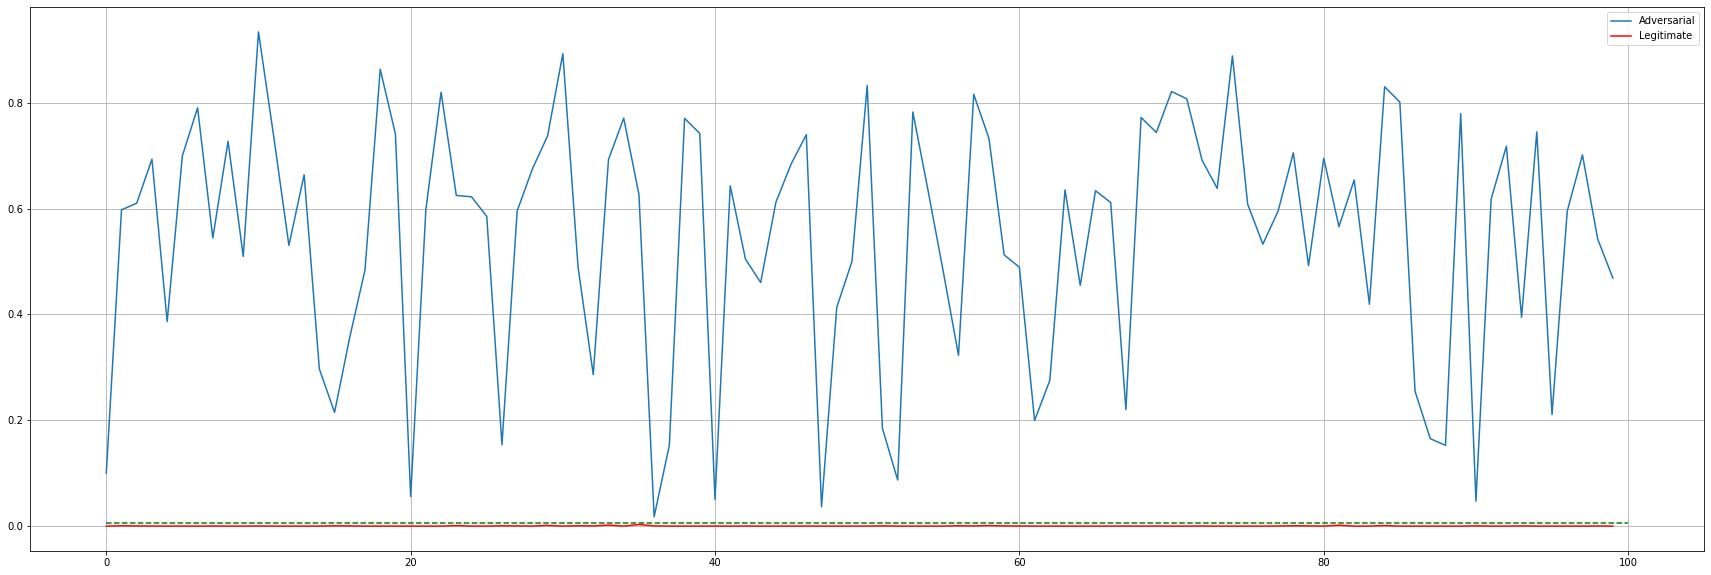

0.00528810289394503
Legitimate Samples  100
Adversarial Samples  100
True Negatives  100
False Positives  0
True Positives  100
False Negatives 0
##########
Detection Ratio TP:  100.0
Detection Ratio FN:  0.0
Detection Ratio TN:  100.0
Detection Ratio FP:  0.0
True Positives: 100
False Positives: 0
True Negatives: 100
False Negatives: 0
Accuracy: 1.0
#######################
#######################
#######################
L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
[0.1]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 38 samples
Calculated train dataset distances
0.5485677123069763
0.0032175490632653236
0.18593534947323956
##########
0.2402448058128357
6.011068762745708e-07
0.01258402107975455
Distance t legitimate mean: 0.01258402107975455
Distance t min-max: 0.12173117743805051
Distance t conservative mean: 0.06715759925890252
Score legitimate mean: 66
Score min-max: 36
Score conservative mean: 50
##########
Max 

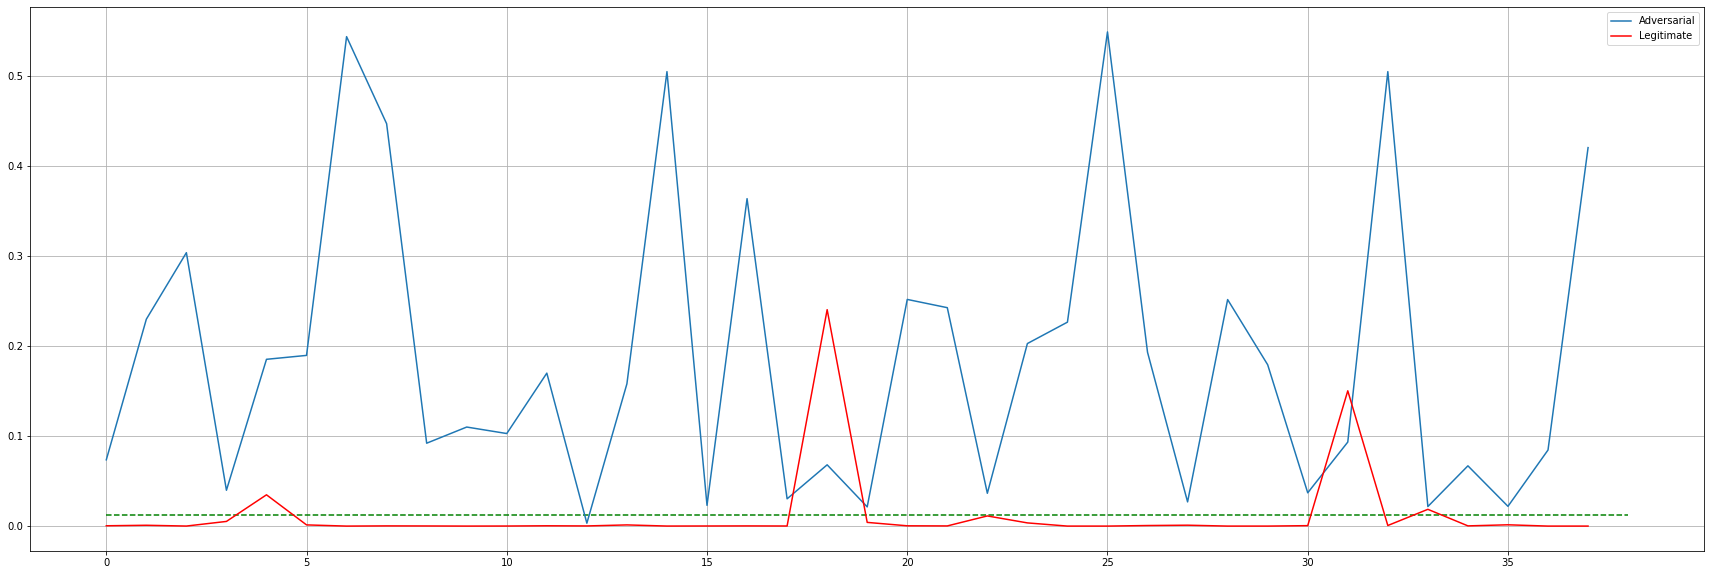

0.01258402107975455
Legitimate Samples  38
Adversarial Samples  38
True Negatives  34
False Positives  4
True Positives  37
False Negatives 1
##########
Detection Ratio TP:  97.36842105263159
Detection Ratio FN:  2.6315789473684212
Detection Ratio TN:  89.47368421052633
Detection Ratio FP:  10.526315789473685
True Positives: 37
False Positives: 5
True Negatives: 34
False Negatives: 2
Accuracy: 0.9102564102564102
#######################
#######################
#######################
L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
[0.5]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 46 samples
Calculated train dataset distances
0.6321759223937988
0.0022893762215971947
0.2184591477777323
##########
0.42305484414100647
1.5425950294911672e-08
0.01810483804784438
Distance t legitimate mean: 0.01810483804784438
Distance t min-max: 0.21267211018130183
Distance t conservative mean: 0.1153884741145731
Score legitimate mean: 7

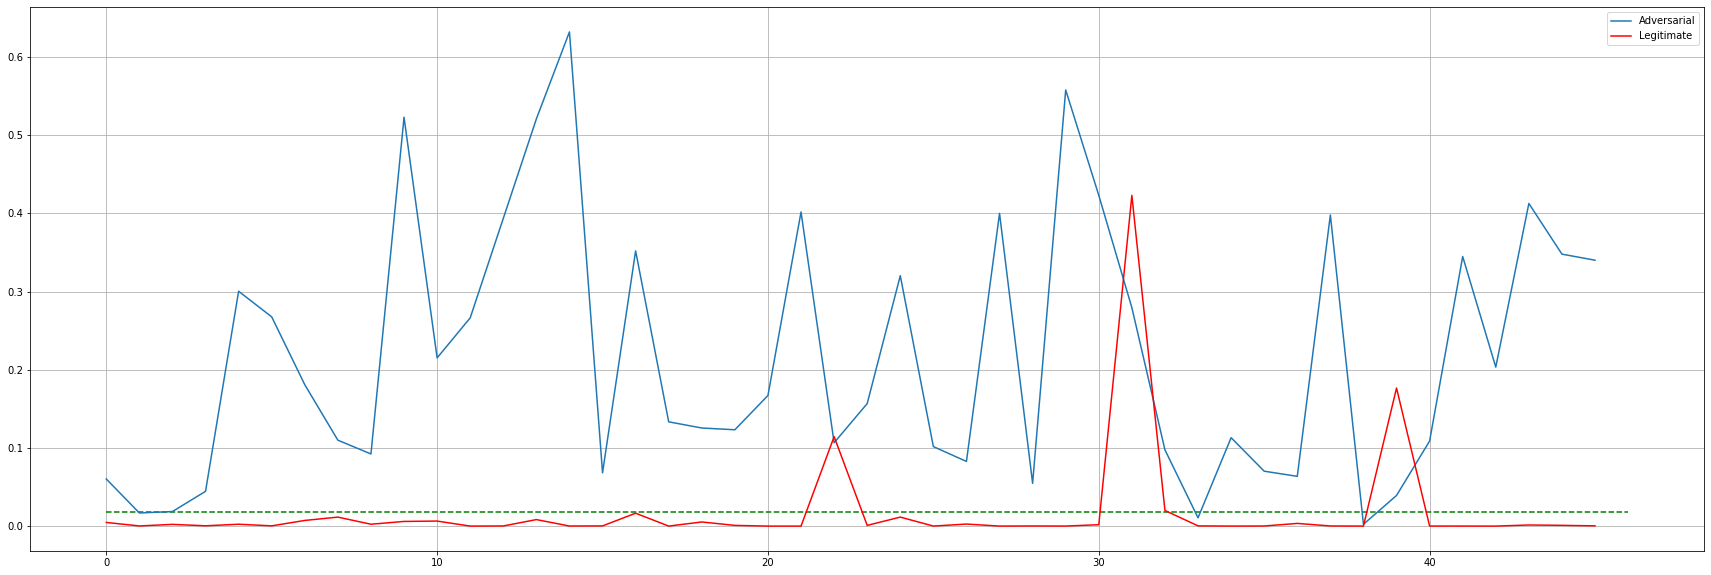

0.01810483804784438
Legitimate Samples  46
Adversarial Samples  46
True Negatives  42
False Positives  4
True Positives  43
False Negatives 3
##########
Detection Ratio TP:  93.47826086956522
Detection Ratio FN:  6.521739130434782
Detection Ratio TN:  91.30434782608695
Detection Ratio FP:  8.695652173913043
True Positives: 44
False Positives: 3
True Negatives: 43
False Negatives: 2
Accuracy: 0.9456521739130435
#######################
#######################
#######################
L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
[1]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 58 samples
Calculated train dataset distances
0.6607866287231445
0.00515371561050415
0.22287121023340473
##########
0.035739362239837646
8.344650268554688e-07
0.0015146450897242207
Distance t legitimate mean: 0.0015146450897242207
Distance t min-max: 0.0204465389251709
Distance t conservative mean: 0.010980592007447559
Score legitimate mean: 9

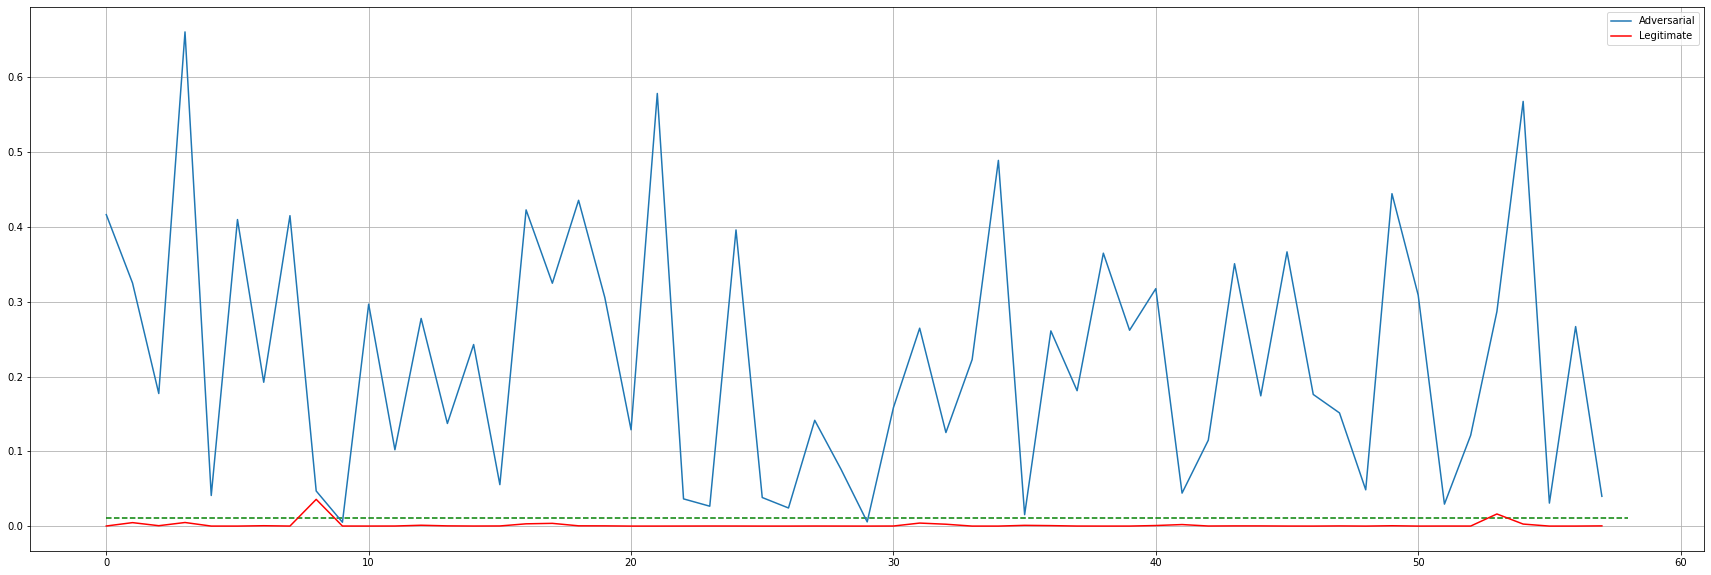

0.010980592007447559
Legitimate Samples  58
Adversarial Samples  58
True Negatives  56
False Positives  2
True Positives  56
False Negatives 2
##########
Detection Ratio TP:  96.55172413793103
Detection Ratio FN:  3.4482758620689653
Detection Ratio TN:  96.55172413793103
Detection Ratio FP:  3.4482758620689653
True Positives: 58
False Positives: 9
True Negatives: 50
False Negatives: 1
Accuracy: 0.9152542372881356
#######################
#######################
#######################
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)
[0.1]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 55 samples
Calculated train dataset distances
0.4961603581905365
0.007841169834136963
0.20434997020797296
##########
0.20921647548675537
1.962527029775174e-08
0.009602143196028801
Distance t legitimate mean: 0.009602143196028801
Distance t min-max: 0.10852882266044617
Distance t conservative mean: 0.059065482

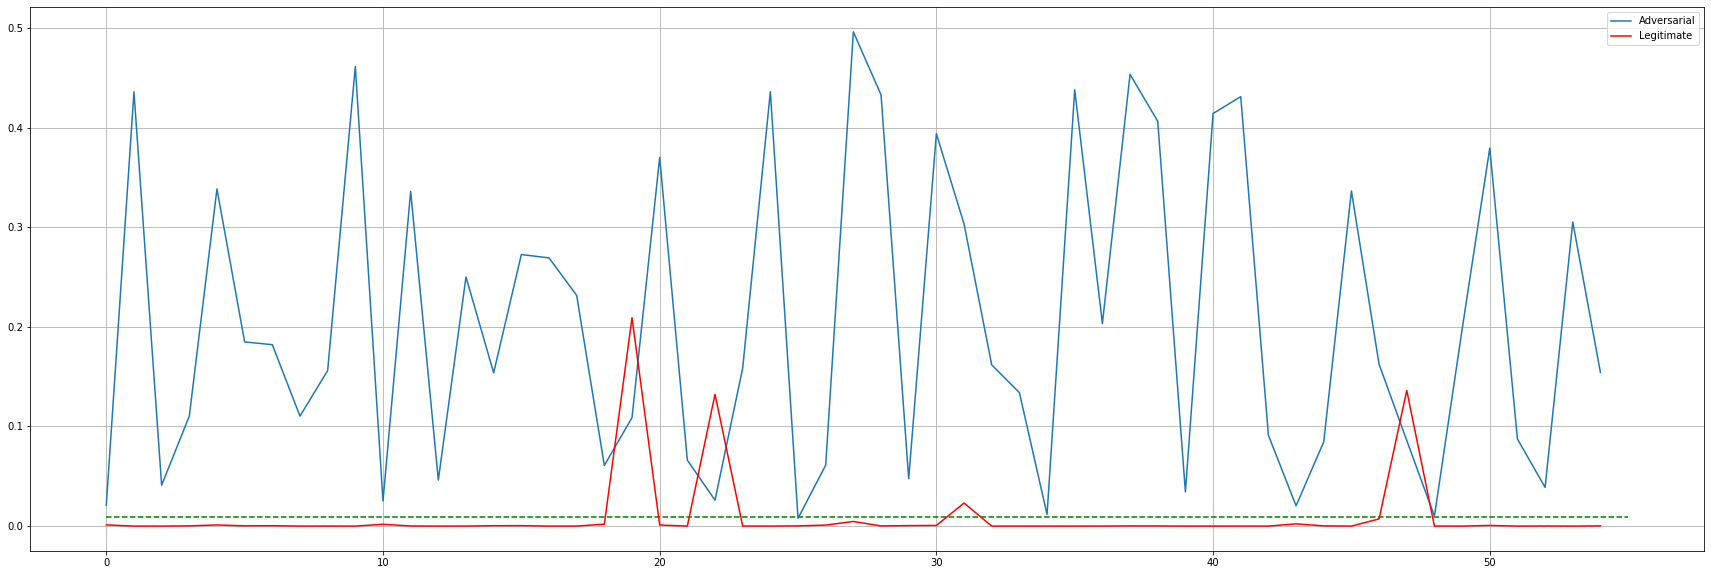

0.009602143196028801
Legitimate Samples  55
Adversarial Samples  55
True Negatives  51
False Positives  4
True Positives  54
False Negatives 1
##########
Detection Ratio TP:  98.18181818181817
Detection Ratio FN:  1.8181818181818181
Detection Ratio TN:  92.72727272727272
Detection Ratio FP:  7.2727272727272725
True Positives: 55
False Positives: 6
True Negatives: 50
False Negatives: 1
Accuracy: 0.9375
#######################
#######################
#######################
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)
[0.5]
torch.Size([1, 28, 28])
Train/Test split after 100 samples
Calculated train dataset distances
0.8453168272972107
0.006407380104064941
0.5209852930530906
##########
0.030369818210601807
1.0934382288496636e-08
0.0014614691727143025
Distance t legitimate mean: 0.0014614691727143025
Distance t min-max: 0.018388599157333374
Distance t conservative mean: 0.009925034165023838
Score legitimate mean: 164
S

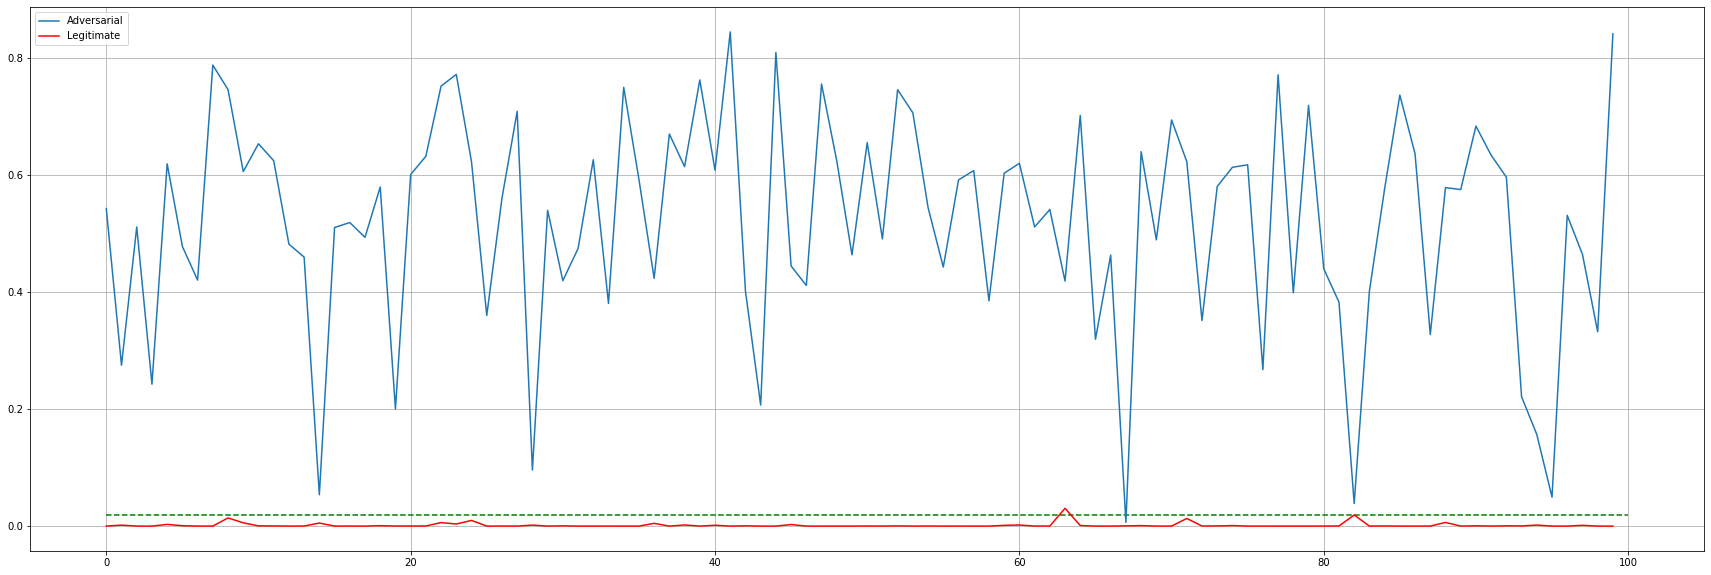

0.018388599157333374
Legitimate Samples  100
Adversarial Samples  100
True Negatives  98
False Positives  2
True Positives  99
False Negatives 1
##########
Detection Ratio TP:  99.0
Detection Ratio FN:  1.0
Detection Ratio TN:  98.0
Detection Ratio FP:  2.0
True Positives: 98
False Positives: 2
True Negatives: 98
False Negatives: 2
Accuracy: 0.98
#######################
#######################
#######################
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)
[1]
torch.Size([1, 28, 28])
Train/Test split after 100 samples
Calculated train dataset distances
0.9980432987213135
0.06356394290924072
0.9220422410964966
##########
0.0005027651786804199
8.171185506000711e-09
2.266077498210173e-05
Distance t legitimate mean: 2.266077498210173e-05
Distance t min-max: 0.03203335404396057
Distance t conservative mean: 0.016028007409471336
Score legitimate mean: 166
Score min-max: 200
Score conservative mean: 200
##########
Ma

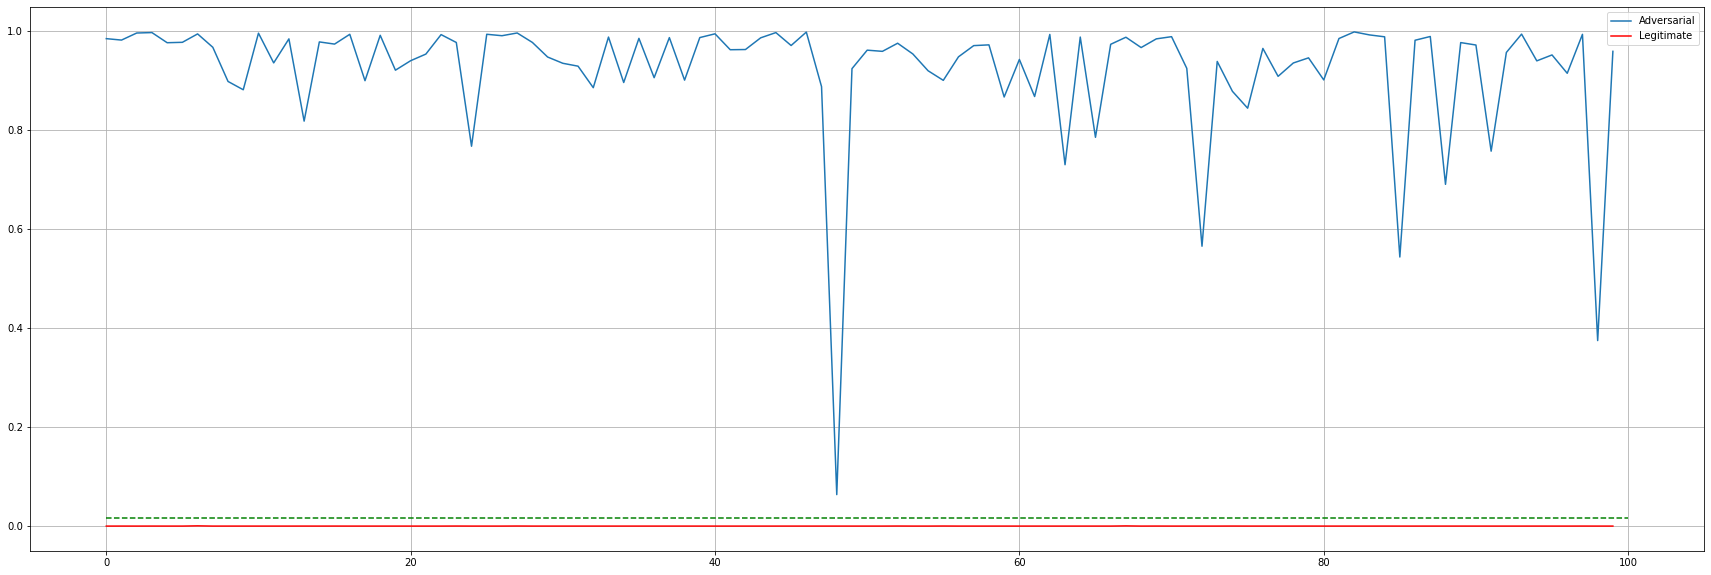

0.016028007409471336
Legitimate Samples  100
Adversarial Samples  100
True Negatives  100
False Positives  0
True Positives  100
False Negatives 0
##########
Detection Ratio TP:  100.0
Detection Ratio FN:  0.0
Detection Ratio TN:  100.0
Detection Ratio FP:  0.0
True Positives: 99
False Positives: 0
True Negatives: 100
False Negatives: 1
Accuracy: 0.995
#######################
#######################
#######################
L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)
[0.1]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 37 samples
Calculated train dataset distances
0.5468457341194153
0.0032163038849830627
0.20005257206188665
##########
0.058094680309295654
1.0945958592856186e-06
0.0033992501836429575
Distance t legitimate mean: 0.0033992501836429575
Distance t min-max: 0.03065549209713936
Distance t conservative mean: 0.017027371140391157
Score legitimate mean: 60
Score min-max: 58
Score conservative 

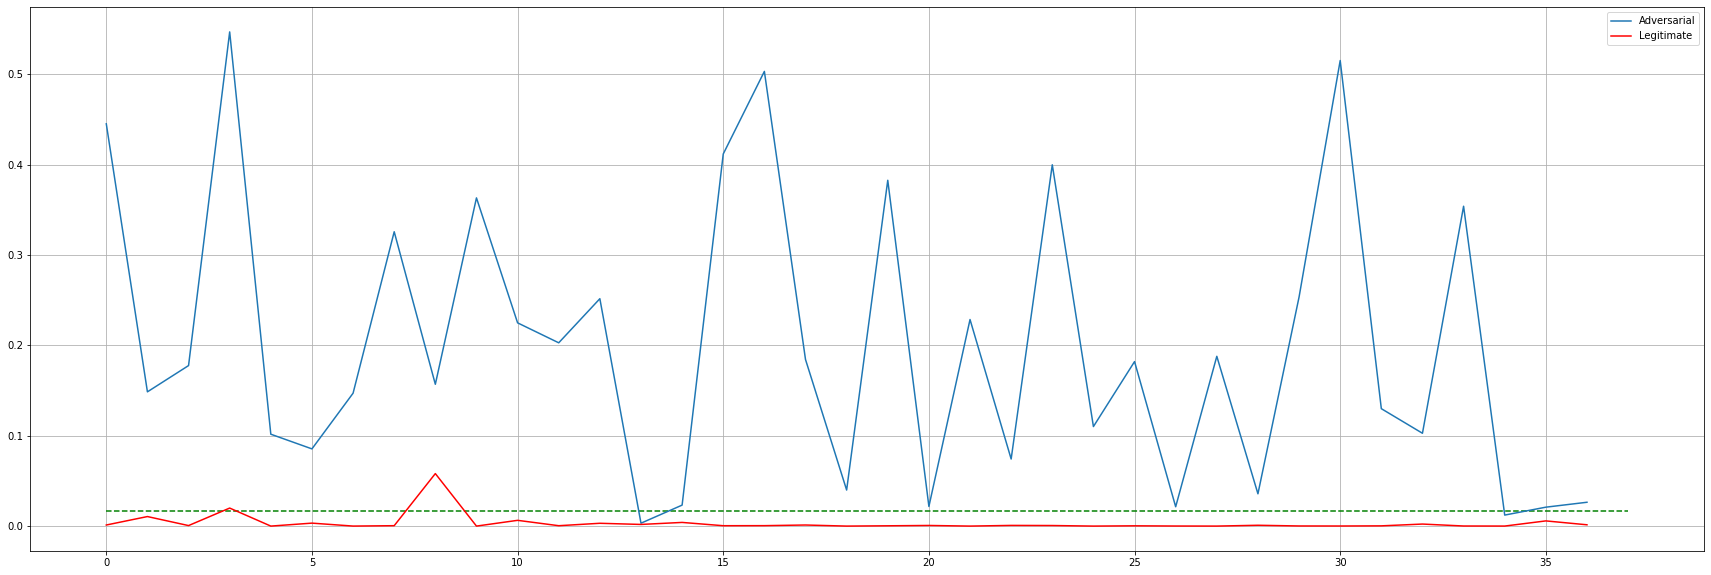

0.017027371140391157
Legitimate Samples  37
Adversarial Samples  37
True Negatives  35
False Positives  2
True Positives  35
False Negatives 2
##########
Detection Ratio TP:  94.5945945945946
Detection Ratio FN:  5.405405405405405
Detection Ratio TN:  94.5945945945946
Detection Ratio FP:  5.405405405405405
True Positives: 37
False Positives: 4
True Negatives: 34
False Negatives: 1
Accuracy: 0.9342105263157895
#######################
#######################
#######################
L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)
[0.5]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 44 samples
Calculated train dataset distances
0.5997745990753174
0.0021673832088708878
0.24616107552058317
##########
0.10145342350006104
2.384185791015625e-07
0.005279529467192002
Distance t legitimate mean: 0.005279529467192002
Distance t min-max: 0.05181040335446596
Distance t conservative mean: 0.02854496641082898
Score legi

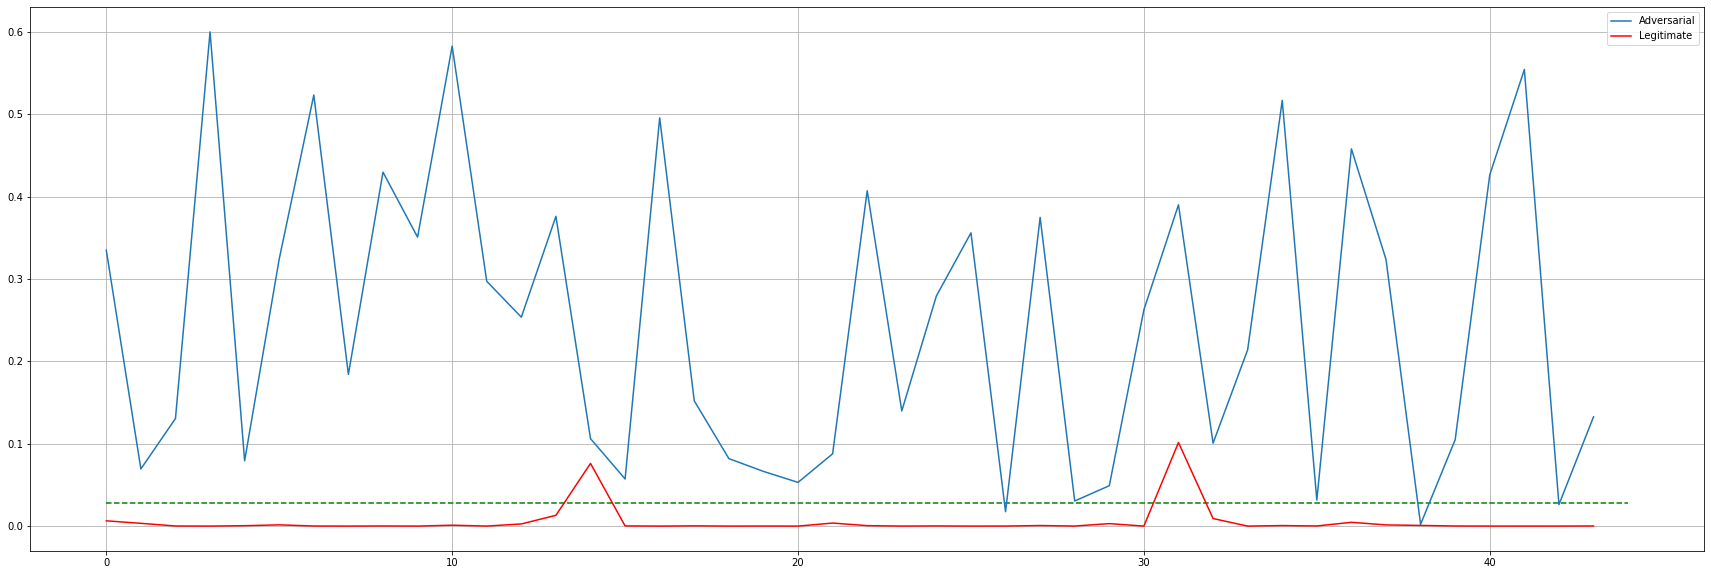

0.02854496641082898
Legitimate Samples  44
Adversarial Samples  44
True Negatives  42
False Positives  2
True Positives  41
False Negatives 3
##########
Detection Ratio TP:  93.18181818181819
Detection Ratio FN:  6.818181818181818
Detection Ratio TN:  95.45454545454547
Detection Ratio FP:  4.545454545454546
True Positives: 39
False Positives: 0
True Negatives: 45
False Negatives: 6
Accuracy: 0.9333333333333333
#######################
#######################
#######################
L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)
[1]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 58 samples
Calculated train dataset distances
0.6048352718353271
0.005259009078145027
0.22761914631801433
##########
0.3663182854652405
1.1920928955078125e-07
0.016707169307774793
Distance t legitimate mean: 0.016707169307774793
Distance t min-max: 0.18578864727169275
Distance t conservative mean: 0.10124790828973378
Score legiti

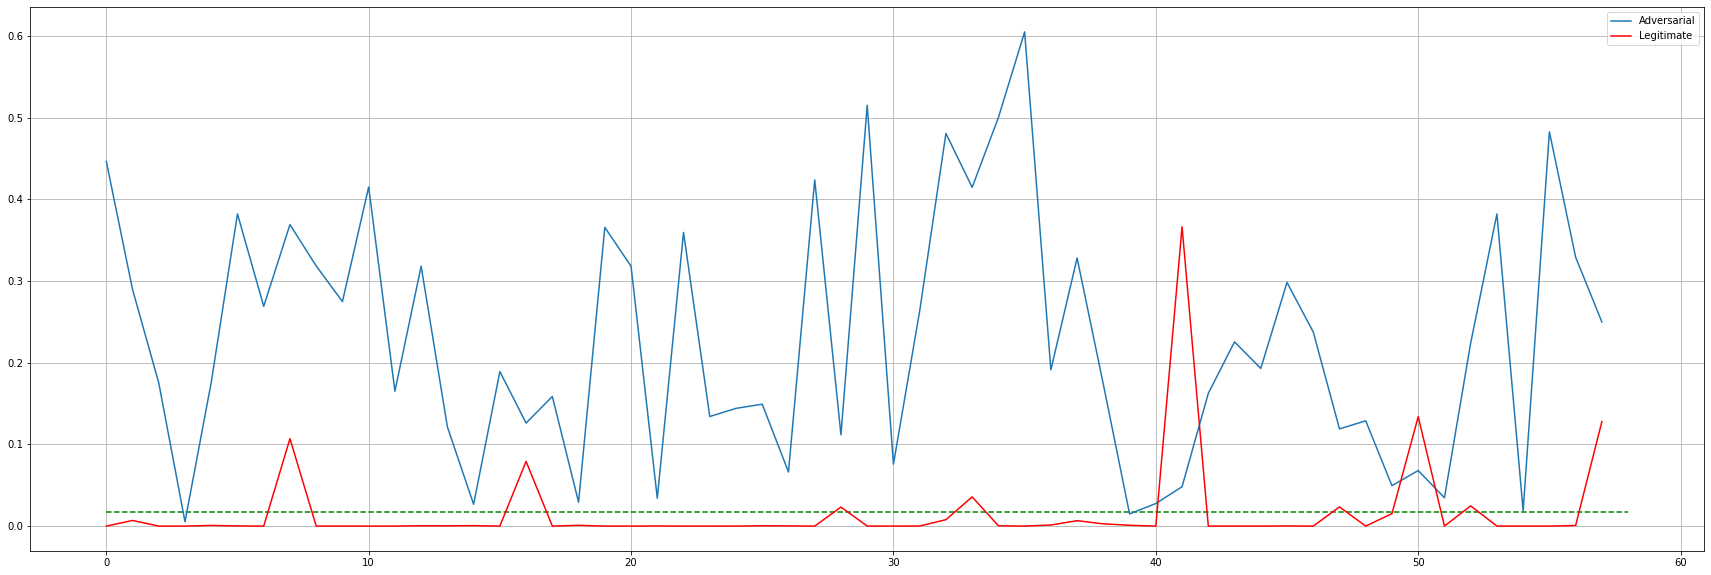

0.016707169307774793
Legitimate Samples  58
Adversarial Samples  58
True Negatives  49
False Positives  9
True Positives  56
False Negatives 2
##########
Detection Ratio TP:  96.55172413793103
Detection Ratio FN:  3.4482758620689653
Detection Ratio TN:  84.48275862068965
Detection Ratio FP:  15.517241379310343
True Positives: 55
False Positives: 3
True Negatives: 55
False Negatives: 3
Accuracy: 0.9482758620689655
#######################
#######################
#######################
L2DeepFoolAttack(steps=50, candidates=10, overshoot=0.02, loss=logits)
[0.1]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 38 samples
Calculated train dataset distances
0.5594367384910583
0.011866703629493713
0.19971286074111336
##########
0.3236026167869568
1.1368466168448776e-08
0.011744726705920411
Distance t legitimate mean: 0.011744726705920411
Distance t min-max: 0.16773466020822525
Distance t conservative mean: 0.08973969345707283
Score legitimate mean: 70
Score min-m

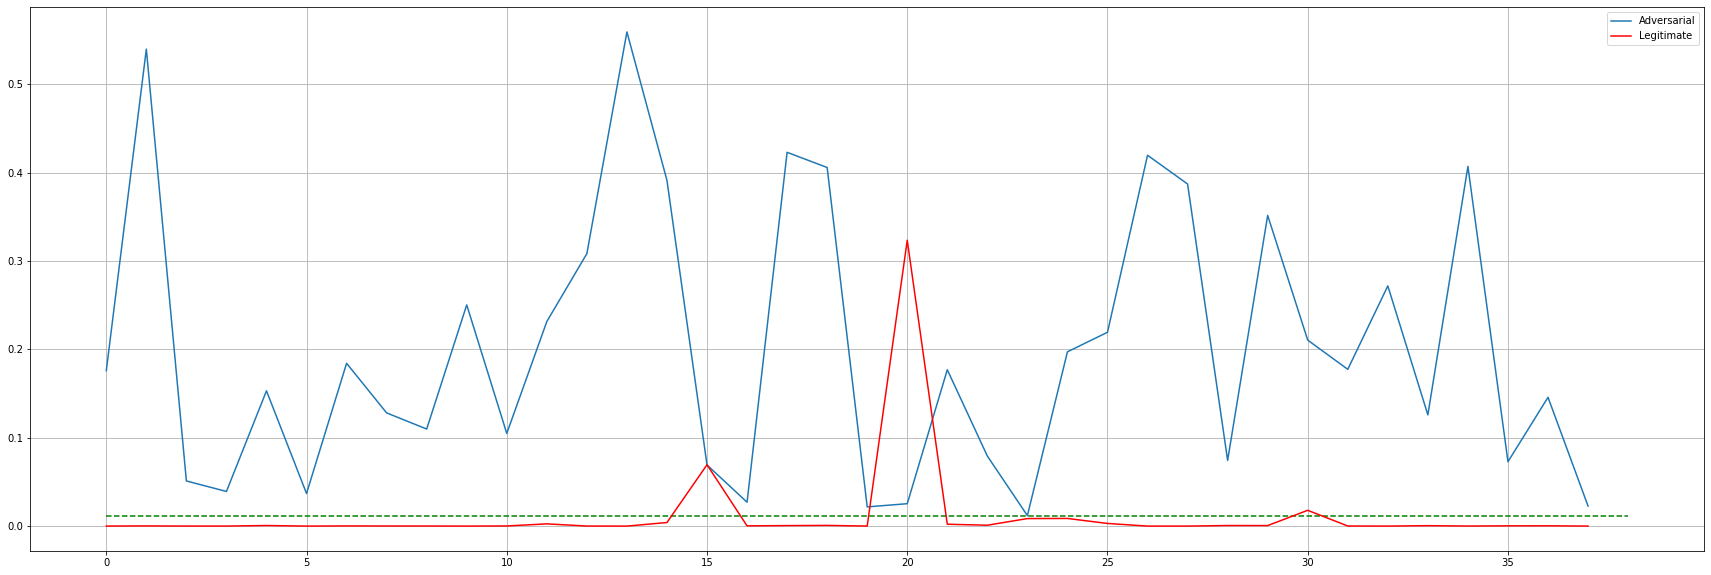

0.011744726705920411
Legitimate Samples  38
Adversarial Samples  38
True Negatives  35
False Positives  3
True Positives  38
False Negatives 0
##########
Detection Ratio TP:  100.0
Detection Ratio FN:  0.0
Detection Ratio TN:  92.10526315789474
Detection Ratio FP:  7.894736842105264
True Positives: 37
False Positives: 5
True Negatives: 34
False Negatives: 2
Accuracy: 0.9102564102564102
#######################
#######################
#######################
L2DeepFoolAttack(steps=50, candidates=10, overshoot=0.02, loss=logits)
[0.5]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 47 samples
Calculated train dataset distances
0.5594367384910583
0.02172841504216194
0.23496216979432613
##########
0.33408236503601074
1.5490857663280622e-07
0.01934463605682123
Distance t legitimate mean: 0.01934463605682123
Distance t min-max: 0.17790539003908634
Distance t conservative mean: 0.09862501304795379
Score legitimate mean: 84
Score min-max: 40
Score conservative mean

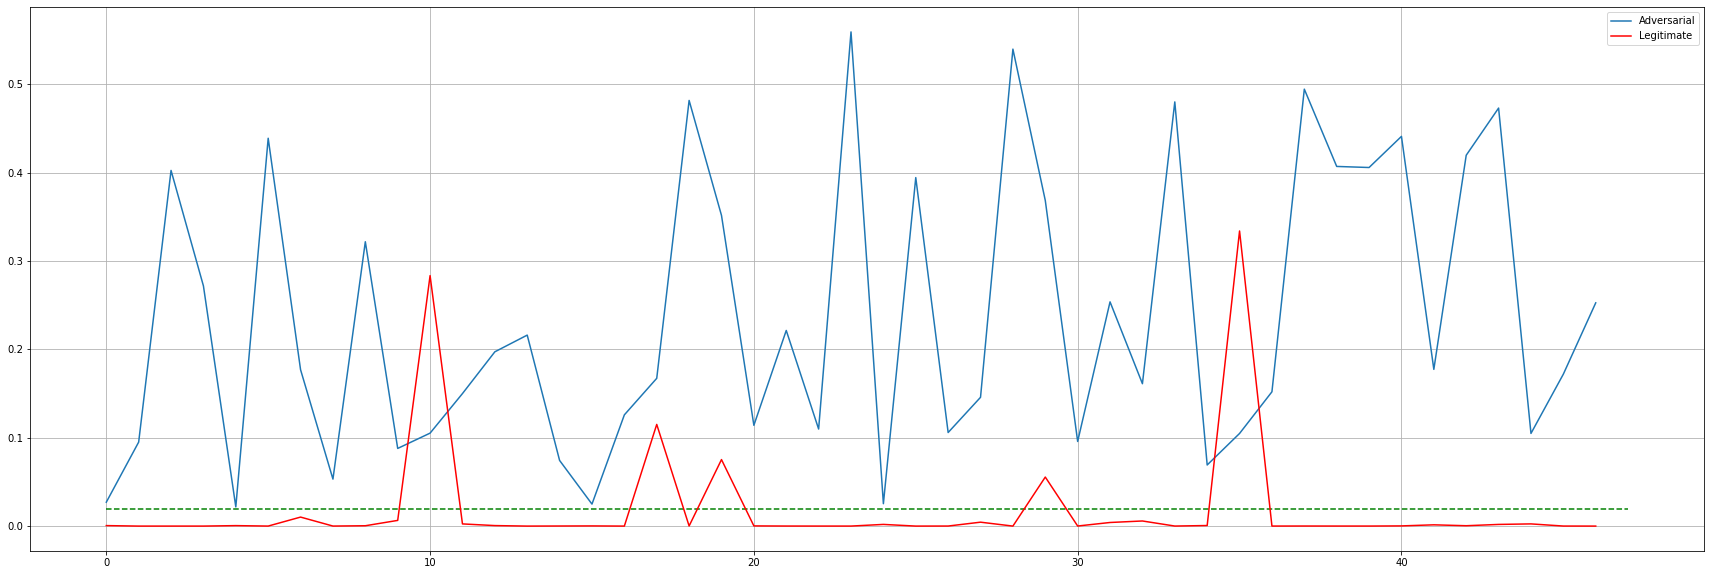

0.01934463605682123
Legitimate Samples  47
Adversarial Samples  47
True Negatives  42
False Positives  5
True Positives  47
False Negatives 0
##########
Detection Ratio TP:  100.0
Detection Ratio FN:  0.0
Detection Ratio TN:  89.36170212765957
Detection Ratio FP:  10.638297872340425
True Positives: 44
False Positives: 8
True Negatives: 40
False Negatives: 4
Accuracy: 0.875
#######################
#######################
#######################
L2DeepFoolAttack(steps=50, candidates=10, overshoot=0.02, loss=logits)
[1]
Not enough adversarial samples
torch.Size([1, 28, 28])
Train/Test split after 63 samples
Calculated train dataset distances
0.5399445295333862
0.0036817193031311035
0.2064663962357574
##########
0.5817979574203491
2.384185791015625e-07
0.01197422066439236
Distance t legitimate mean: 0.01197422066439236
Distance t min-max: 0.2927398383617401
Distance t conservative mean: 0.15235702951306623
Score legitimate mean: 114
Score min-max: 32
Score conservative mean: 74
##########


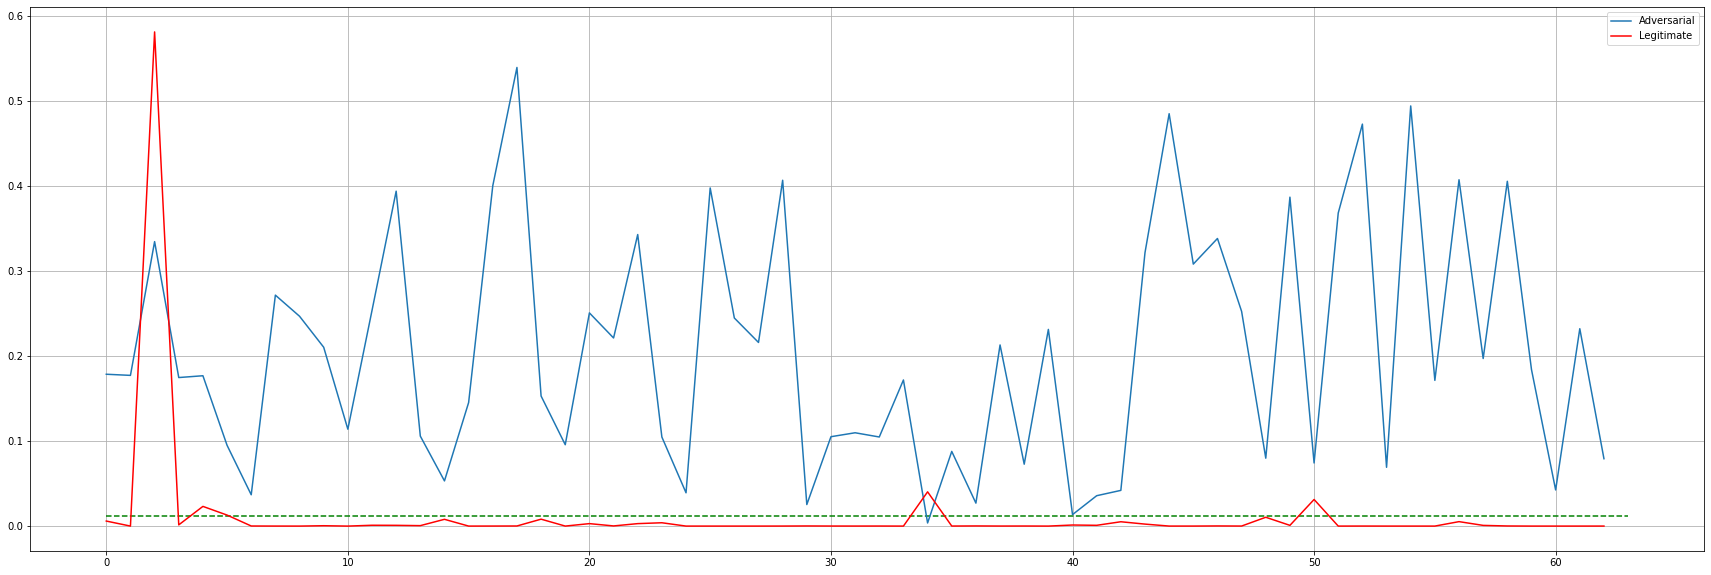

0.01197422066439236
Legitimate Samples  63
Adversarial Samples  63
True Negatives  58
False Positives  5
True Positives  62
False Negatives 1
##########
Detection Ratio TP:  98.4126984126984
Detection Ratio FN:  1.5873015873015872
Detection Ratio TN:  92.06349206349206
Detection Ratio FP:  7.936507936507936
True Positives: 62
False Positives: 6
True Negatives: 58
False Negatives: 2
Accuracy: 0.9375


In [18]:
calculate_mnist(fb.attacks.FGSM(),[0.1])
calculate_mnist(fb.attacks.FGSM(),[0.5])
calculate_mnist(fb.attacks.FGSM(),[1])
#
calculate_mnist(fb.attacks.FGM(),[0.1])
calculate_mnist(fb.attacks.FGM(),[0.5])
calculate_mnist(fb.attacks.FGM(),[1])
#
calculate_mnist(fb.attacks.PGD(),[0.1])
calculate_mnist(fb.attacks.PGD(),[0.5])
calculate_mnist(fb.attacks.PGD(),[1])
#
calculate_mnist(fb.attacks.L2PGD(),[0.1])
calculate_mnist(fb.attacks.L2PGD(),[0.5])
calculate_mnist(fb.attacks.L2PGD(),[1])
#
calculate_mnist(fb.attacks.deepfool.L2DeepFoolAttack(),[0.1])
calculate_mnist(fb.attacks.deepfool.L2DeepFoolAttack(),[0.5])
calculate_mnist(fb.attacks.deepfool.L2DeepFoolAttack(),[1])

##########################

In [116]:
ad_data,ad_label,original_data,original_label = generate_pertubated_examples(n=200,attack_method=fb.attacks.L2PGD(),epsilon=[1],datatype="MNIST") #unten

[1]
Not enough adversarial samples
torch.Size([1, 28, 28])


In [117]:
ad_data.shape

torch.Size([134, 1, 28, 28])

In [118]:
original_data.shape

torch.Size([200, 1, 28, 28])

### FOR CIFAR!

In [147]:
x = ad_data
y = original_data
train_data_adv = torch.empty(0,3,28,28)
train_data_orig = torch.empty(0,3,28,28)

for i in range(100):
    train_data_adv = torch.cat((train_data_adv,x[i].reshape(1,3,28,28)),dim=0)
for i in range(100):
    train_data_orig = torch.cat((train_data_orig,y[i].reshape(1,3,28,28)),dim=0)
#! This
train_data = torch.cat((train_data_adv,train_data_orig),dim=0)

########

x = ad_data
y = original_data
test_data_adv = torch.empty(0,3,28,28)
test_data_orig = torch.empty(0,3,28,28)
for i in range(100,200):
    test_data_adv = torch.cat((test_data_adv,x[i].reshape(1,3,28,28)),dim=0)
for i in range(100,200):
    test_data_orig = torch.cat((test_data_orig,y[i].reshape(1,3,28,28)),dim=0)
test_data = torch.cat((test_data_adv,test_data_orig),dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


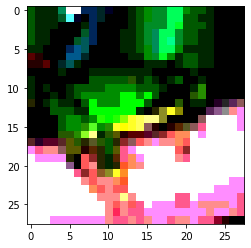

In [227]:
original_data[0].shape
plt.imshow(np.transpose(bit_reduction(train_data[66]), axes=[1, 2, 0]))

In [119]:
#data_com = torch.cat((ad_data,original_data),dim=1) #dim0 for mnist, dim1 for cifar
#label_com = torch.cat((ad_label,original_label),dim=0)

cut = int(min(len(ad_data),len(original_data))/2)
print("Train/Test split after {} samples".format(cut))
data_train = torch.cat((ad_data[0:cut],original_data[0:cut]),dim=0) #! MNIST, CIFAR deactivate line
label_train = torch.cat((ad_label[0:cut],ad_label[0:cut]),dim=0)

if (len(ad_data)<=len(original_data)):
    data_test = torch.cat((ad_data[cut:len(ad_data)],original_data[cut:len(ad_data)]),dim=0) #! MNIST
    label_test = torch.cat((ad_label[cut:len(ad_data)],ad_label[cut:len(ad_data)]),dim=0)
else:
    data_test = torch.cat((ad_data[cut:len(original_data)],original_data[cut:len(original_data)]),dim=0) #! MNIST
    label_test = torch.cat((ad_label[cut:len(original_data)],ad_label[cut:len(original_data)]),dim=0)
# CIFAR
#print(data_train.shape)
#data_train=data_train.reshape(100,3,28,28)
#print(data_train.shape)

Train/Test split after 67 samples


In [16]:
len(data_test)

98

In [14]:
def evaluation_paper (dataset,labelset,network,t=0.01,evaluate=False,datatype="MNIST"):
        differences = []
        is_attack = True
        pertubated_detected = 0
        false_positive = 0
        false_negative = 0
        true_positive = 0
        true_negative = 0
        #if (datatype=="CIFAR"):
                #dataset=dataset.reshape(100,3,28,28)
        for i, (data,target) in enumerate(zip(dataset,labelset),0):
                if (datatype=="MNIST"):
                        data = data.unsqueeze(dim=1)
                if (datatype=="CIFAR"):
                        print(data.shape)
                        data = data.reshape(1,3,28,28)
                with torch.no_grad():
                        output = network(data)
                        # Output median smoothed ensemble
                        median_smoothed_batch=torch.clone(data)
                        median_smoothed_batch = median_smoothing(median_smoothed_batch,kernel_size=2)
                        output_ms = network(median_smoothed_batch)
                        # Output bit reduced ensemble
                        bit_reduced_batch=torch.clone(data)
                        bit_reduced_batch = bit_reduction(bit_reduced_batch, bit=1)
                        output_br = network(bit_reduced_batch)
                        # Test accuracy
                        pred = output.data.max(1, keepdim=True)[1]
                        pred_ms = output_ms.data.max(1, keepdim=True)[1]
                        pred_br = output_br.data.max(1, keepdim=True)[1]

                        output_ens = (output + output_ms + output_br)/3# Average of three networks. Alternative is to use majority voting using output.data.max(1)[1] for each output and write it to an array to get argmax
                        pred_ens = output_ens.data.max(1, keepdim=True)[1]

                        softmax_baseline= F.softmax(output, dim=1)
                        softmax_median_smooth = F.softmax(output_ms, dim=1)
                        softmax_bitreduction = F.softmax(output_br, dim=1)
                        #!
                        #!
                        #if (i==49):
                        #        plt.imshow(np.transpose(data.reshape(3,28,28), axes=[1, 2, 0]))
                        #        plt.show()
                        #if (i==50):
                        #        plt.imshow(np.transpose(data.reshape(3,28,28), axes=[1, 2, 0]))
                        #        plt.show()
                        #!
                        # Jury Vote for ensemble predictions
                        for x in range(len(pred)):

                        # Calculate distance between baseline and rectificated softmax outputs
                                difference_ms=abs((softmax_baseline[x])-(softmax_median_smooth[x]))
                                difference_br=abs((softmax_baseline[x])-(softmax_bitreduction[x]))

                                distance_list=[max(difference_br).item(),max(difference_ms).item()]
                                #difference_total = statistics.fmean(distance_list)
                                difference_total = max(distance_list)
                                #print(difference_total)
                                #print(i)
                                #print("Max Tensor Distance:", difference_total)
                                differences.append(difference_total)
                                if (evaluate):
                                        if ((difference_total > t) and (i<=(len(dataset)/2)-1)):
                                                true_positive += 1
                                        if ((difference_total > t) and (i>(len(dataset)/2)-1)):
                                                false_positive += 1
                                        if ((difference_total < t) and (i<=(len(dataset)/2)-1)):
                                                false_negative += 1
                                        if ((difference_total < t) and (i>(len(dataset)/2)-1)):
                                                true_negative += 1
        if (evaluate):                        
                print("True Positives:",true_positive)
                print("False Positives:",false_positive)
                print("True Negatives:",true_negative)
                print("False Negatives:",false_negative)

                print("Accuracy:",(true_positive+true_negative)/(true_positive+true_negative+false_negative+false_positive))
        else:
                print("Calculated train dataset distances")
        a = [0]*int((len(dataset)/2))
        b = [1]*int((len(dataset)/2))
        c = b + a
        return(differences,c)

In [120]:
differences,adversarial_map=evaluation_paper(data_train,label_train,network=network,datatype="MNIST")
#data_train = MNIST
#train_data = CIFAR!

Calculated train dataset distances


Text(0, 0.5, 'Distance')

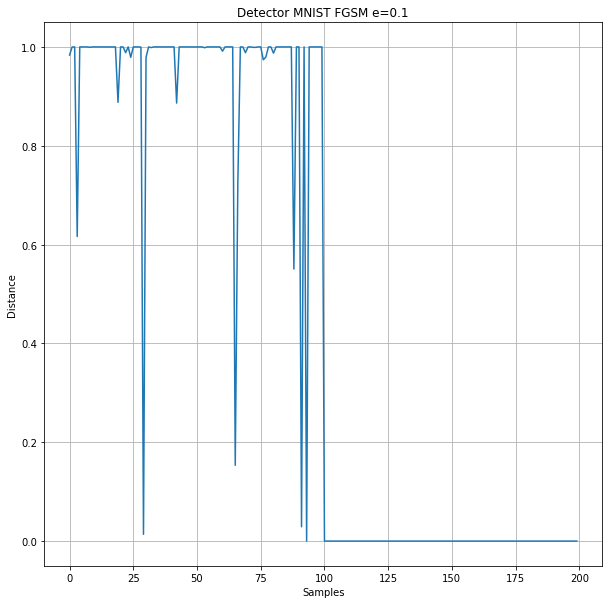

In [112]:
plt.figure(figsize=(10,10))
plt.plot(differences)
plt.grid()
plt.title("Detector MNIST FGSM e=0.1")
plt.xlabel("Samples")
plt.ylabel("Distance")

0.980314314365387
5.841255187988281e-06
0.4306701863512098
##########
0.13496851921081543
1.7070538212657653e-16
0.003206863545204364
Distance t legitimate mean: 0.003206863545204364
Distance t min-max: 0.06748718023300171
Distance t conservative mean: 0.035347021889103034
Score legitimate mean: 116
Score min-max: 104
Score conservative mean: 104
##########
Max Score: 116
Min Score: 104
Mean Score: 108.0
##########
Evaluated legitimate mean calculation as best threshold for t
True T Distance:  104
True T Adaptive:  104
True T Legitimate Mean:  116
Detection Ratio True T Distance:  162.61194029850748
Detection Ratio False T Distance:  22.388059701492537
Detection Ratio True T Adaptive:  162.61194029850748
Detection Ratio False T Adaptive:  22.388059701492537
Detection Ratio True T Mean:  177.56716417910448
Detection Ratio False T Mean:  13.432835820895523


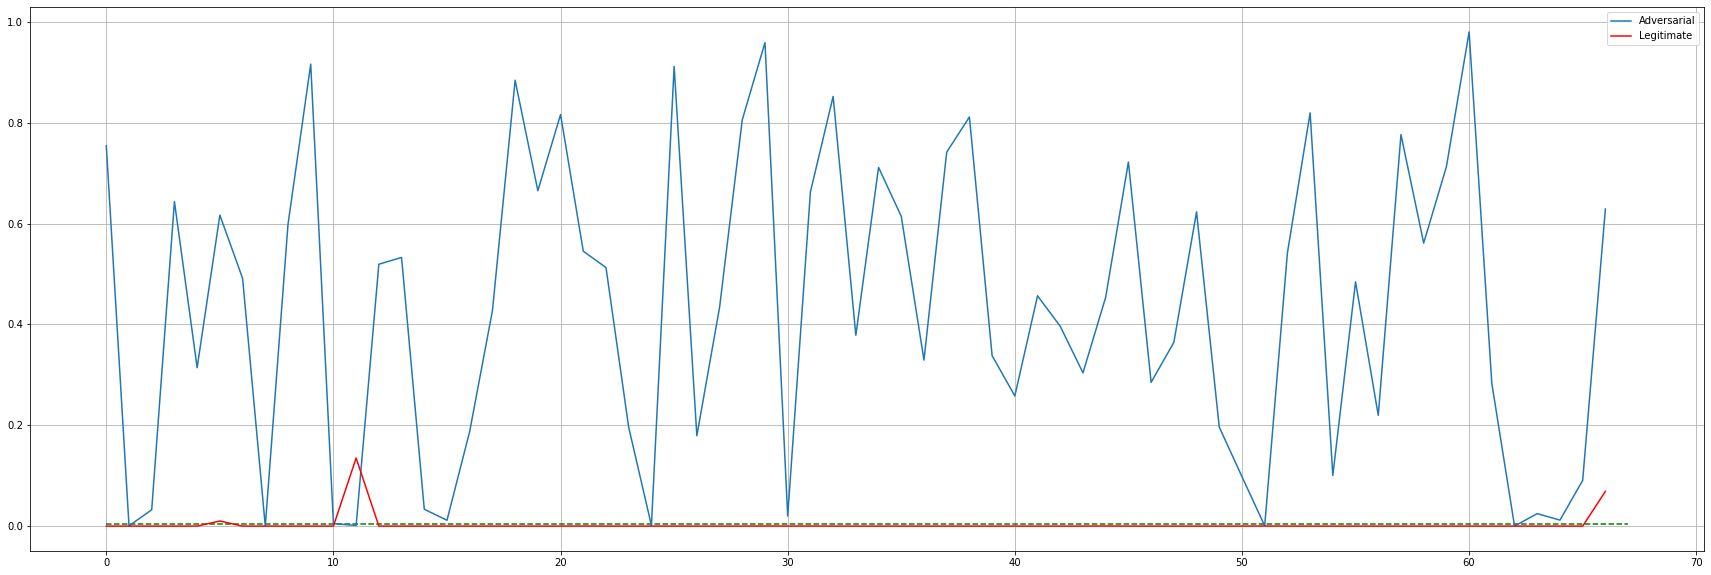

0.003206863545204364
Legitimate Samples  67
Adversarial Samples  67
True Negatives  64
False Positives  3
True Positives  61
False Negatives 6
##########
Detection Ratio TP:  91.044776119403
Detection Ratio FN:  8.955223880597016
Detection Ratio TN:  95.5223880597015
Detection Ratio FP:  4.477611940298508


In [121]:
t_value=calculate_threshold_adversarial(differences,adversarial_map,correction_t=1.0,print_output=True)

In [122]:
differences=evaluation_paper(data_test,label_test,network,t_value,evaluate=True,datatype="MNIST")

True Positives: 63
False Positives: 1
True Negatives: 66
False Negatives: 4
Accuracy: 0.9626865671641791


# Test site

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

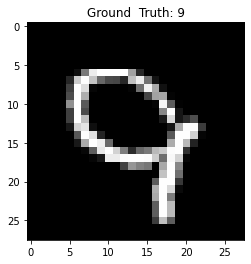

In [125]:
plt.imshow(f_d[0][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[0]))
plt.plot


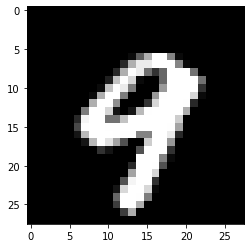

In [55]:
plt.imshow(ndimage.median_filter(f_d[0][0], size=2), cmap='gray', interpolation='none')

2


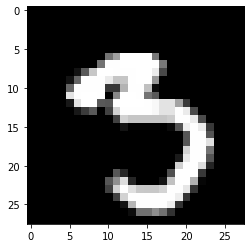

In [167]:
plt.imshow(median_smoothing(f_d[0][0]), cmap='gray', interpolation='none')

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

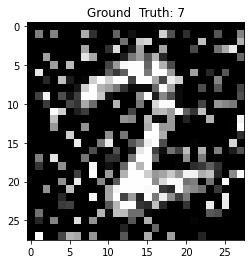

In [258]:
plt.imshow(pertubated_image[0][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[5]))
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

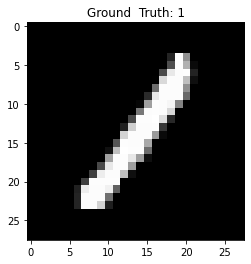

In [78]:
plt.imshow(x_d[5][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[5]))
plt.plot

In [163]:
median_smoothed = median_smoothing(f_d)
scaled_data = bit_reduction(f_d)
pertubated_image = perturbate_image(p_d,mode='random') #Pertubations seems to make in-place operations so use different tensor

In [189]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)

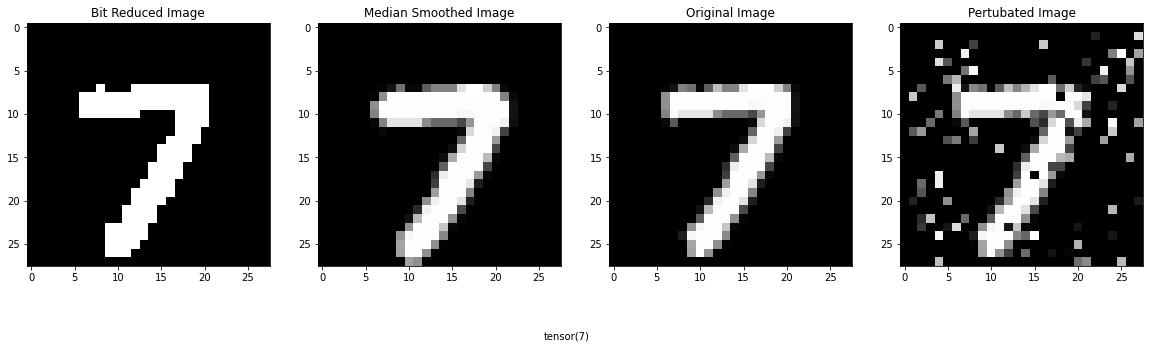

In [164]:
batch_nr = 0
fig = plt.figure()

ax1 = fig.add_subplot(141)  # left side
ax2 = fig.add_subplot(142)  # right side
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.title.set_text("Bit Reduced Image")
ax2.title.set_text("Median Smoothed Image")
ax3.title.set_text("Original Image")
ax4.title.set_text("Pertubated Image")
ax1.imshow(scaled_data[batch_nr][0], cmap='gray', interpolation='none')
ax2.imshow(median_smoothed[batch_nr][0], cmap='gray', interpolation='none')
ax3.imshow(x_d[batch_nr][0], cmap='gray', interpolation='none')
ax4.imshow(pertubated_image[batch_nr][0], cmap='gray', interpolation='none')
fig.text(.5, .05, e_d[batch_nr], ha='center')
fig.set_figheight(6)
fig.set_figwidth(20)
#plt.title("Ground  Truth: {}".format(e_d[batch_nr]))
plt.show()

# Tst perturbated example

Model predicted: tensor([2])
Model predicted median smoothed: tensor([2])
Model predicted scaled: tensor([2])
##################################################################
Model predicted tensor value: 19.3311767578125
Model predicted median smoothed tensor value: 19.64731216430664
Model predicted scaled tensor value: 19.95734405517578
##################################################################
Model real: 2
Sum pixel: 784
Pertubated pixel: 95
Percent preturbated: 0.1211734693877551


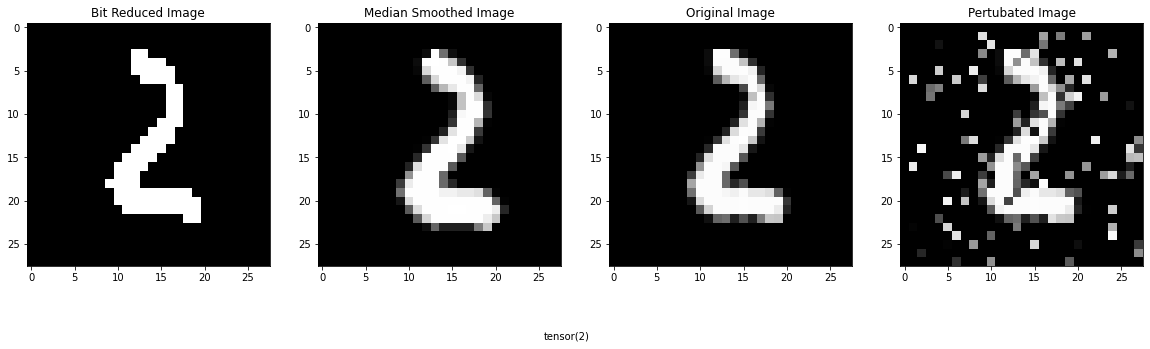

In [462]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)
#networks= (network,network2,network3)

pertubated_image = perturbate_image(p_d,mode='random') #Pertubations seems to make in-place operations so use different tensor
image = f_d
fake_tst = test_fake(image,network)

median_smoothed = median_smoothing(image)
scaled_data = bit_reduction(image)


fake_tst_median = test_fake(median_smoothed,network)
fake_tst_scaled = test_fake(scaled_data,network)


p_percent,p_size,p_pertubated=count_perturbated_pixel(x_d,pertubated_image)
print("Model predicted: {}".format(fake_tst.data.max(1, keepdim=True)[1][0]))
print("Model predicted median smoothed: {}".format(fake_tst_median.data.max(1, keepdim=True)[1][0]))
print("Model predicted scaled: {}".format(fake_tst_scaled.data.max(1, keepdim=True)[1][0]))

print("##################################################################")
print("Model predicted tensor value: {}".format(fake_tst.data.max(1)[0][0]))
print("Model predicted median smoothed tensor value: {}".format(fake_tst_median.data.max(1)[0][0]))
print("Model predicted scaled tensor value: {}".format(fake_tst_scaled.data.max(1)[0][0]))

print("##################################################################")
print("Model real: {}".format(e_d[0]))
print("Sum pixel: {}".format(p_size))
print("Pertubated pixel: {}".format(p_pertubated))
print("Percent preturbated: {}".format(p_percent))

####

batch_nr = 0
fig = plt.figure()

ax1 = fig.add_subplot(141)  # left side
ax2 = fig.add_subplot(142)  # right side
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.title.set_text("Bit Reduced Image")
ax2.title.set_text("Median Smoothed Image")
ax3.title.set_text("Original Image")
ax4.title.set_text("Pertubated Image")
ax1.imshow(scaled_data[batch_nr][0], cmap='gray', interpolation='none')
ax2.imshow(median_smoothed[batch_nr][0], cmap='gray', interpolation='none')
ax3.imshow(x_d[batch_nr][0], cmap='gray', interpolation='none')
ax4.imshow(pertubated_image[batch_nr][0], cmap='gray', interpolation='none')
fig.text(.5, .05, e_d[batch_nr], ha='center')
fig.set_figheight(6)
fig.set_figwidth(20)
#plt.title("Ground  Truth: {}".format(e_d[batch_nr]))
plt.show()


In [32]:
%run "c:\GIT\Programme\code\Master\Koch\Robustness of Generative Adversial Networks\src\Models\upgraded_net_hook.py"

In [31]:
%run "c:\GIT\Programme\code\Master\Koch\Robustness of Generative Adversial Networks\src\functions\f2d.py"

upgraded_net_hook.nn

Train:


AttributeError: module 'upgraded_net_hook' has no attribute 'ResNet20'